# Relazione finale per il primo progetto Big Data (2021)

**Nome Gruppo**: Big Data Gregori-Wood

**Componenti**: Luca Gregori & Alessandro Wood
# Indice


1. **Analisi Dataset**

2. **Specifiche Hardware e Software**

3. **Job 1**
  - 3.1 Implementazione Map Reduce
  - 3.2 Implementazione Hive
  - 3.3 Implementazione Spark Core
  - 3.4 Output
  - 3.5 Grafici
4. **Job 2**
  - 4.1 Implementazione Map Reduce
  - 4.2 Implementazione Hive
  - 4.3 Implementazione Spark Core
  - 4.4 Output
  - 4.5 Grafici
5. **Job 3**
  - 5.1 Implementazione Map Reduce
  - 5.2 Implementazione Hive
  - 5.3 Implementazione Spark Core
  - 5.4 Output
  - 5.5 Grafici


#1. Analisi e Preparazione Dataset

In [ ]:
import pandas as pd

In [ ]:
print("Importazione....")

dataset = pd.read_csv('/content/drive/MyDrive/historical_stock_prices.csv', parse_dates=['date'])

dataset_stocks = pd.read_csv('/content/drive/MyDrive/historical_stocks.csv')

print("Completato!")


Importazione....
Completato!


##1.1 analisi di historical_stock_prices

In [ ]:
dataset.shape

In [ ]:
dataset.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


Quanti valori nulli ci sono?

In [ ]:
dataset.isnull().values.sum()

0

Ci sono record duplicati?

In [ ]:
len(hsp.groupby(['ticker', 'date'])) != dataset.shape[0]

Si procede con ulteriori controlli e con l'eventuale eliminazione di record non consistenti.

In [ ]:
dt = dataset[dataset["low"] > dataset["high"]]
print("Records in cui il minimo è maggiore del massimo: %d" % len(dt))

dataset = dataset[dataset["low"] <= dataset["high"]]
print("Nuovo numero di records dopo il drop: %d" % len(dataset))

Entries in cui il minimo è maggiore del massimo: 48
Numero di entries: 20973841


In [ ]:
dt = dataset[(dataset["low"] > dataset["open"]) | (dataset["low"] > dataset["close"])]
print("Records in cui il minimo è maggiore di open oppure di close: %d" % len(dt))

dataset = dataset[(dataset["low"] <= dataset["open"]) & (dataset["low"] <= dataset["close"])]
print("Numero di records dopo il drop: %d" % len(dataset))

Entries in cui il minimo è maggiore di open oppure  di close: 940
Numero di entries: 20972901


In [ ]:
dt = dataset[(dataset["high"] < dataset["open"]) | (dataset["high"] < dataset["close"])]
print("Records in cui il massimo è minore di open oppure di close: %d" % len(dt))

dataset = dataset[(dataset["high"] >= dataset["open"]) & (dataset["high"] >= dataset["close"])]
print("Numero di records dopo il drop: %d" % len(dataset))

Entries in cui il massimo è minore di open oppure di close: 1088
Numero di entries: 20971813


In [ ]:
condition = (dataset["volume"] < 0) | (dataset["low"] < 0) | (dataset["high"]  < 0) | (dataset["open"] < 0) | (dataset["close"] < 0)
dt = dataset[condition]
print("Records con valori negativi: %d" % len(dt))

Records con valori negativi: 0


Dal momento che non ci serve la feature *adj_close*, procediamo con la sua eliminazione

In [ ]:
dataset = dataset.drop('adj_close', 1)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20971813 entries, 0 to 20973888
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ticker  object        
 1   open    float64       
 2   close   float64       
 3   low     float64       
 4   high    float64       
 5   volume  int64         
 6   date    datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.3+ GB


##1.2 analisi di historical_stocks

In [ ]:
dataset.stocks.shape

In [ ]:
dataset_stocks.head()

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS


In [ ]:
dataset_stocks.describe()

,ticker,exchange,name,sector,industry
count,6460,6460,6460,5020,5020
unique,6460,2,5462,13,136
top,MTBCP,NASDAQ,BANK OF AMERICA CORPORATION,FINANCE,MAJOR PHARMACEUTICALS
freq,1,3308,16,1022,419


Come si può vedere a fronte di 6460 righe ci sono solamente 5462 valori univoci per name. Questo indica che più ticker possono essere associati allo stesso name. Segue un esempio di name associato a più tickers.

In [ ]:
max = dataset_stocks.groupby('name')['ticker'].nunique().max()
idmax = dataset_stocks.groupby('name')['ticker'].nunique().idxmax()
print("L'azienda %s è associata a %d tickers") % (max, idmax))
lst = list(dataset_stocks[dataset_stocks['name'] == max].groupby(['name', 'ticker']).groups.keys())
print(lst)

In [ ]:
dataset_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6460 entries, 0 to 6459
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ticker    6460 non-null   object
 1   exchange  6460 non-null   object
 2   name      6460 non-null   object
 3   sector    5020 non-null   object
 4   industry  5020 non-null   object
dtypes: object(5)
memory usage: 252.5+ KB


I campi sector e industry hanno valori nulli. È importante tenerlo a mente per il **job 2**.

## 1.3 Dataset

### Dataset cleaned
Non è altro che il dataset **historical_stock_prices** con tutte le modifiche effettuate nei passi precedenti.


In [ ]:
dataset.to_csv('/content/drive/MyDrive/historical_stock_prices_cleaned.csv', index = False)

### Dataset sampled

Creato facendo un sampled del 10% del **dataset cleaned** senza alterare i dati.



In [ ]:
dataset_sampled = dataset.sample(frac=0.10)
dataset.to_csv('/content/drive/MyDrive/historical_stock_prices_sampled.csv', index = False)

### Dataset increased

Creato facendo una copia del dataset originale e alterando tutti i dati.

Nello specifico sono state applicate funzioni hash sha1 per alterare le stringhe come *ticker* e *name*, mentre i valori numerici sono stati alterati randomicamente in un certo range.

Sono stati inoltre riapplicati tutti i controlli di consistenza visti precedentemente.

In [ ]:

import hashlib
import random

dataset_copied = dataset.copy()
dataset_stocks_copied = dataset_stocks.copy()


dataset_copied["ticker"] = dataset_copied["ticker"].map(lambda x: hashlib.sha1(x.encode("UTF-8")).hexdigest()[:5].upper())
dataset_copied["open"] = dataset["open"].map(lambda x: random.uniform(x * 0.75, x * 1.25))
dataset_copied["close"] = dataset["close"].map(lambda x: random.uniform(x * 0.75, x * 1.25))
dataset_copied["low"] = dataset["low"].map(lambda x: random.uniform(x * 0.75, x))
dataset_copied["high"] = dataset["high"].map(lambda x: random.uniform(x, x * 1.25))
dataset_copied["volume"] = dataset["volume"].map(lambda x: int(random.uniform(x * 0.75, x * 1.25)))

dataset_copied = dataset_copied[dataset_copied["low"] <= dataset_copied["high"]]
dataset_copied = dataset_copied[(dataset_copied["low"] <= dataset_copied["open"]) & (dataset_copied["low"] <= dataset_copied["close"])]
dataset_copied = dataset_copied[(dataset_copied["high"] >= dataset_copied["open"]) & (dataset_copied["high"] >= dataset_copied["close"])]

dataset_stocks_copied["ticker"] = dataset_stocks_copied["ticker"].map(lambda x: hashlib.sha1(x.encode("UTF-8")).hexdigest()[:5].upper())
dataset_stocks_copied["name"] = dataset_stocks_copied["name"].map(lambda x: hashlib.sha1(x.encode("UTF-8")).hexdigest()[:15].upper())

print("Il dataset avrà %d righe in più" %(len(dataset_copied)))

dataset.append(dataset_copied)
dataset_stocks.append(dataset_stocks_copied)

""" Salvataggio su disco """

dataset.to_csv('dataset/historical_stock_prices_increased.csv', index = False)
dataset_stocks.to_csv('dataset/historical_stocks_increased.csv', index = False)

### Plot Grafici
Sono contenuti tutti i tempi di esecuzione di MapReduce, Hive e Spark per tutti e tre dataset, e una funzione utile per plottare i grafici che verrà usata più volte nei capitoli successivi.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

fileSizes =  {"sampled": 170, "cleaned": 1700, "increased": 2400}

job1_mapreduce_local = {"sampled": 40, "cleaned": 384, "increased": 532}
job2_mapreduce_local = {"sampled": 18, "cleaned": 170, "increased": 255}
job3_mapreduce_local = {"sampled": 33, "cleaned": 119, "increased": 180}
job1_spark_local = {"sampled": 23, "cleaned": 172, "increased": 178}
job2_spark_local = {"sampled": 13, "cleaned": 53, "increased": 73}
job3_spark_local = {"sampled": 9, "cleaned": 42, "increased": 77}
job1_hive_local = {"sampled": 202, "cleaned": 425 , "increased": 597}
job2_hive_local = {"sampled": 123, "cleaned": 302, "increased": 547}
job3_hive_local = {"sampled": 295, "cleaned": 483, "increased": 686}


job1_mapreduce_cluster = {"sampled": 35, "cleaned": 162, "increased": 177}
job2_mapreduce_cluster = {"sampled": 31, "cleaned": 100, "increased": 114}
job3_mapreduce_cluster = {"sampled": 29, "cleaned": 76, "increased": 84}
job1_spark_cluster = {"sampled": 34, "cleaned": 180, "increased": 181}
job2_spark_cluster = {"sampled": 23, "cleaned": 75, "increased": 78}
job3_spark_cluster = {"sampled": 15, "cleaned": 77, "increased": 83}
job1_hive_cluster = {"sampled": 58, "cleaned": 160 , "increased": 162}
job2_hive_cluster = {"sampled": 56, "cleaned": 103, "increased": 113}
job3_hive_cluster = {"sampled": 323, "cleaned": 262, "increased": 301}

def selectJob(jobNumber):

  if jobNumber == 1: return {"local": (job1_mapreduce_local, job1_hive_local, job1_spark_local), 
                             "cluster": (job1_mapreduce_cluster, job1_hive_cluster, job1_spark_cluster)}
  if jobNumber == 2: return {"local": (job2_mapreduce_local, job2_hive_local, job2_spark_local),
                             "cluster": (job2_mapreduce_cluster, job2_hive_cluster, job2_spark_cluster)}
  if jobNumber == 3: return {"local": (job3_mapreduce_local, job3_hive_local, job3_spark_local),
                             "cluster": (job3_mapreduce_cluster, job3_hive_cluster, job3_spark_cluster)}
  return None

def compareOnLocalMachineAndCluster(jobNumber):

    job_mapreduce_local, job_hive_local, job_spark_local = selectJob(jobNumber)["local"]
    job_mapreduce_cluster, job_hive_cluster, job_spark_cluster = selectJob(jobNumber)["cluster"]

    f,ax = plt.subplots(1, 2, figsize=(24, 12))

    sns.lineplot(x=fileSizes.values(), y = job_mapreduce_local.values(), marker="o", label="MapReduce", ax=ax[0])
    sns.lineplot(x=fileSizes.values(), y = job_hive_local.values(), marker="o", label="Hive", ax=ax[0])
    sns.lineplot(x=fileSizes.values(), y = job_spark_local.values(), marker="o", label="Spark", ax=ax[0])

    ax[0].set_title('Comparazione MapReduce, Hive e Spark su macchina locale per il job %d' % (jobNumber))
    ax[0].set_xlabel("File size (MB)")
    ax[0].set_ylabel("Time (s)")

    sns.lineplot(x=fileSizes.values(), y = job_mapreduce_cluster.values(), marker="o", label="MapReduce", ax=ax[1])
    sns.lineplot(x=fileSizes.values(), y = job_hive_cluster.values(), marker="o", label="Hive", ax=ax[1])
    sns.lineplot(x=fileSizes.values(), y = job_spark_cluster.values(), marker="o", label="Spark", ax=ax[1])

    ax[1].set_title('Comparazione MapReduce, Hive e Spark su cluster per il job %d' % (jobNumber))
    ax[1].set_xlabel("File size (MB)")
    ax[1].set_ylabel("Time (s)")
    
    
    return


#2. Specifiche hardware e software

Verranno ora fornite le specifiche hardware e software della macchina locale e del cluster su cui sono stati eseguiti i job.

Si precisa come i job MapReduce siano stati scritti in Python ed eseguiti utilizzando Hadoop Streaming (https://hadoop.apache.org/docs/r3.0.3/hadoop-streaming/HadoopStreaming.html).

Per quanto riguarda Spark, gli script sono stati scritti sempre in Python.
##2.1 Macchina locale
L'esecuzione dei job in spark è stata effettuata in local usando 6 thread mentre quella di Hive è stata effettuata con hadoop.
###Specifiche hardware
```
Amd Ryzen 7 5800x Eight core a 4.1GHz
16 GB di RAM
80 GB di memoria secondaria (SSD)
```
###Specifiche software
```
Java 1.8.0_292
Python 3.8.5
Hadoop 3.2.2
Hive 2.3.8
Spark 3.1.1
```
##2.2 Cluster

Il cluster è stato realizzato utilizzando il servizio Amazon Web Services (s3 buckets, EMR cluster)

L'esecuzione di Spark e Hive è stata effettuata con yarn.

###Specifiche hardware
```
3 istanze m5.xlarge
```

###Specifiche software
```
Java 1.8.0_272
Python 3.7.9
Hadoop Distribution Amazon-2.10.1
Hive 2.3.7
Spark 2.4.2
```



#3. Job 1 (con facoltativa)

###Specifiche

Un job che sia in grado di generare un report contenente, per ciascuna azione: (a) la data della prima quotazione, (b) la
data dell’ultima quotazione, (c) la variazione percentuale della quotazione (differenza percentuale tra il primo e l’ultimo
prezzo di chiusura presente nell’archivio), (d) il prezzo massimo e quello minimo e (e) (facoltativo) il massimo numero
di giorni consecutivi in cui l’azione è cresciuta (chiusura maggiore dell’apertura) con indicazione dell’anno in cui questo
è avvenuto. Il report deve essere ordinato per valori decrescenti del punto b.

###Premesse

Nel **task facoltativo** (**e**) per il calcolo dei giorni consecutivi sono stati considerati esclusivamente i record presenti nel dataset dopo il preprocessamento. Se ad esempio di 3 giorni consecutivi il secondo non è presente nel dataset allora il conteggio sarà pari a 1. Si precisa inoltre che il massimo dei giorni consecutivi può essere anche 0, come ad esempio nel caso di un unica data relativa ad un ticker presente nel dataset che non rispetta la condizione close maggiore di open.

## 3.1 Implementazione in MapReduce

###Mapper

Il mapper effettua una banale selezione, scartando il valore del volume poiché inutile per quanto concerne il job. La chiave del record in output è (ticker, data) in quanto viene successivamente effettuato un ordinamento secondario sui record per data ascendente, utile per il **task facoltativo** (**e**).

```python
class Mapper:
    
    map(key, record):
        ticker, open, close, low, high, _, date = record
        key = ticker, date
        value = open, close, low, high
        emit(key, value)
```

###Reducer
Il reducer, per ogni ticker, trova il suo record più vecchio (*ticker_2_first_date*) e quello più recente (*ticker_2_last_date*) e i valori di close associati ad essi, utilizzandoli per il calcolo dell’incremento percentuale (*var*) che il ticker ha ottenuto nel periodo. Al contempo calcola il valore massimo di high (*ticker_2_highest*) e il minimo di low (*ticker_2_lowest*).
Per quanto riguarda il **task facoltativo** (**e**), dato che le date sono ordinate in modo ascendente, è stato memorizzato per ciascun ticker la data del record precedente (*ticker_2_prev_date*) in modo tale da fare un confronto con la data del record attuale (*date*). Se la differenza fra le due è pari a 1(i.e. sono giorni consecutivi) e per entrambi i record il close è maggiore dell’open, viene incrementato il contatore relativo al ticker, invece viene posto a 1 se non sono consecutivi ma il close è maggiore dell’open,  altrimenti  il contatore viene azzerato.        
Ad ogni iterazione si controlla se il contatore attuale è maggiore di quello massimo. Qualora lo fosse allora il contatore attuale diventa il nuovo massimo. 



```python
class Reducer:

  setup():
    initializes all dictionaries

  reduce(key, record):
    ticker, date = key
    open, close, low, high = record

    ticker_2_first_date[ticker] = min(ticker_2_first_date[ticker], date)
    ticker_2_last_date[ticker] = max(ticker_2_last_date[ticker], date)

    ticker_2_first_close[ticker] = close where ticker_2_first_date[ticker] == date
    ticker_2_last_close[ticker] = close where ticker_2_last_date[ticker] == date
    ticker_2_lowest[ticker] = min(ticker_2_last_date[ticker], low)
    ticker_2_highest[ticker] = max(ticker_2_last_date[ticker], high)

    prev_date = ticker_2_prev_date[ticker]
    diff = date - prev_date

    if close > open:
        if diff == 1:
            ticker_2_crescita_corrente[ticker] += 1
        else:
            ticker_2_crescita_corrente[ticker] = 1
    else:
        ticker_2_crescita_corrente[ticker] = 0

    if ticker_2_crescita_corrente[ticker] >= ticker_2_crescita_max[ticker]:
        ticker_2_crescita_max[ticker] = ticker_2_crescita_corrente[ticker]
    
    ticker_2_prev_date[ticker] = date
    
  print_result():
    for ticker, last_date in sorted(ticker_2_last_date):
      var = (ticker_2_last_close[ticker] - ticker_2_first_close[ticker]) / (ticker_2_first_close[ticker]) * 100
      row = ticker, ticker_2_first_date[ticker], last_date, var, ticker_2_lowest[ticker], ticker_2_highest[ticker], ticker_2_crescita_max[ticker]
      emit(first_ten_rows)
  


##3.2 Implementazione Hive
I record vengono aggregati per ticker, trovando la data più vecchia e quella più recente per ognuno e calcolando successivamente l’incremento percentuale (t*icker_percentuale)* sulla base dei close relativi a tali date (*ticker_close_min_data* e t*icker_close_max_data*). Inoltre vengono calcolati per ogni ticker il valore massimo del high e il minimo del low. Tutti i minimi e massimi sono salvati preventivamente nella tabella *ticker_min_max_data*.


Per quanto riguarda il **task facoltativo** (**e**) è stato istanziata una tabella ticker_ordered_date
con un ordinamento per ticker e data, e successivamente tramite partizione di valori di questi ultimi è stato assegnato, ad ogni gruppo di record dello stesso ticker aventi date consecutive, lo stesso valore (*GRP*), calcolato come la differenza fra la data del record e *1900-01-01* meno il numero di riga della partizione. Si veda *ticker_giorni_consecutivi* per i dettagli.

Qui di seguito un esempio di calcolo di *GRP*:

| ticker | Date       | differenza con *1900-01-01*| *row_number* relativo alla partition | *GRP* |
| ---- | ---------- | ----- | --- |  --------------- |
| GOOG | 2018-01-02 | 43100 | 1 |43100 - 1 = 43099 |
| GOOG | 2018-01-03 | 43101 | 2 |43101 - 2 = 43099 |
| GOOG | 2018-04-05 | 43193 | 1 |43193 - 1 = 43192 |
| GOOG | 2018-04-06 | 43194 | 2 |43193 - 2 = 43192 |

A questo punto vengono contati (con il *row_number*) i giorni consecutivi sulla base di una partizione per ticker e *GRP* ordinata per ticker e data  (*the_real_ticker_giorni_consecutivi*). Viene infine calcolato il massimo di questo valore per ogni ticker nella tabella *the_more_real_ticker_giorni_consecutivi*.

Questo espediente per il calcolo del task facoltativo è basato sul metodo **Tabibito-san** ("viaggiatore" in Giapponese), una metodologia utilizzata per trovare gruppi di numeri consecutivi in SQL.




```sql
DROP TABLE IF EXISTS historical_stock_prices;
CREATE TABLE historical_stock_prices(ticker STRING, open DOUBLE, close DOUBLE, low DOUBLE, high DOUBLE, volume DOUBLE, data DATE) row format delimited fields terminated by ',';

LOAD DATA LOCAL INPATH '/home/alessandro/historical_stock_prices_sampled.csv' OVERWRITE INTO TABLE historical_stock_prices;

DROP TABLE IF EXISTS ticker_giorni_consecutivi;
DROP TABLE IF EXISTS ticker_min_max_data;
DROP TABLE IF EXISTS ticker_close_max_data;
DROP TABLE IF EXISTS ticker_close_min_data;
DROP TABLE IF EXISTS ticker_ordered_date;
DROP TABLE IF EXISTS ticker_percentuale;
DROP TABLE IF EXISTS solution;
DROP TABLE IF EXISTS solution;

CREATE TABLE ticker_min_max_data AS
SELECT ticker, MIN(data) AS min_data, MAX(data) AS max_data, MIN(low) AS min_low, MAX(HIGH) as max_high
FROM historical_stock_prices
GROUP BY ticker;

CREATE TABLE ticker_close_min_data AS
SELECT h.ticker, h.data, h.close
FROM ticker_min_max_data AS t, historical_stock_prices AS h
WHERE h.ticker = t.ticker AND h.data = t.min_data;

CREATE TABLE ticker_close_max_data AS
SELECT h.ticker, h.data, h.close
FROM ticker_min_max_data AS t, historical_stock_prices AS h
WHERE h.ticker = t.ticker AND h.data = t.max_data;

CREATE TABLE ticker_percentuale AS
SELECT tmin.ticker, (((tmax.close - tmin.close)/tmin.close) * 100) AS inc_perc
FROM ticker_close_max_data AS tmax JOIN ticker_close_min_data AS tmin on tmax.ticker = tmin.ticker;

CREATE TABLE ticker_ordered_date AS
SELECT h.ticker, h.data, h.open, h.close
FROM historical_stock_prices as h
WHERE close > open
ORDER BY ticker, data;

CREATE TABLE ticker_giorni_consecutivi AS
SELECT ticker, data, (DATEDIFF(data , '1900-01-01') - ROW_NUMBER() OVER( PARTITION BY ticker ORDER BY ticker, data) ) AS GRP
FROM  ticker_ordered_date;

CREATE TABLE the_real_ticker_giorni_consecutivi AS
SELECT ticker, (ROW_NUMBER() OVER( PARTITION BY ticker, GRP ORDER BY ticker, data)) AS giorni
FROM ticker_giorni_consecutivi
ORDER BY ticker;

CREATE TABLE the_more_real_ticker_giorni_consecutivi AS
SELECT ticker, MAX(giorni) AS maxi
FROM the_real_ticker_giorni_consecutivi
GROUP BY ticker;

CREATE TABLE solution AS
SELECT t1.ticker, min_data AS first_date, max_data AS last_date, inc_perc, min_low, max_high, NVL(maxi, 0)
FROM ticker_min_max_data AS t1 JOIN ticker_percentuale AS t2
    ON t1.ticker = t2.ticker  LEFT JOIN the_more_real_ticker_giorni_consecutivi AS t3 ON t2.ticker = t3.ticker
ORDER BY last_date DESC, ticker ASC
LIMIT 10;

```



##3.3 Implementazione Spark Core

I record vengono aggregati per ticker, trovando per ciascuno di essi la data più vecchia (*min_data_close*) e quella più recente (*max_data_close*) e calcolando l’incremento percentuale (*incremento_percentuale*) sulla base dei close relativi a tali date. Inoltre vengono calcolati per ogni ticker il valore massimo del high (*max_ticker_high*) e il minimo del low (*min_ticker_low*).

Per quanto riguarda il **task facoltativo** (**e**) vengono inizialmente filtrati i record in cui il close è non maggiore dell’open, viene riportato su un unico record il ticker con la lista delle date associate ad esso, sulla quale viene lanciata la funzione *count_max_consec_days(lst)*, che ritorna il massimo dei giorni consecutivi.
Tuttavia, poichè sono stati filtrati precedentemente i record con close non maggiore di open, i ticker interamente filtrati vengono reinseriti nel result con una left outer join dove i valori *None* vengono sostituiti con 0.



```python

def count_max_consec_days(lst):

    max_count, count = 0, 1
    lst = sorted(lst)

    for i in range(len(lst) - 1):
        d1 = lst[i]
        d2 = lst[i + 1]
        diff = (d1 - d2)
        if diff == 1:
            count += 1
        else:
            count = 1

        if count > max_count:
            max_count = count

    return max_count


input_RDD = sparkContext.textFile(input_filepath).cache().map(line -> line.split(","))
input_RDD = input_RDD.filter(line -> line[TICKER] != "ticker")

max_data_close = input_RDD.map(line -> (line[TICKER], (line[CLOSE], line[DATE]))).reduceByKey(x, y -> close_max_date(x, y))
min_data_close = input_RDD.map(line -> (line[TICKER], (line[CLOSE], line[DATE]))).reduceByKey(x, y -> close_min_date(x, y))

max_consec_days = input_RDD\
    .filter(line[CLOSE] > line[OPEN])\
    .map(line -> (line[TICKER], [line[DATE]])) \
    .reduceByKey(x, y -> x concat y) \
    .map(line -> (line[TICKER], count_max_consec_days(line[DATE_LIST])))

min_ticker_low = input_RDD.map(line -> (line[TICKER], (line[LOW]))).reduceByKey(x, y -> min(x, y))
max_ticker_high = input_RDD.map(line -> (line[TICKER], line[HIGH])).reduceByKey(x, y -> max(x, y))

join_min_con_max = min_data_close.join(max_data_close)
incremento_percentuale = join_min_con_max.map(line -> (line[TICKER], (line[CLOSE_MAX_DATA]) - line[CLOSE_MIN_DATA]) / line[CLOSE_MIN_DATA]]) * 100))

result = min_data_close.join(max_data_close) \
    .join(incremento_percentuale) \
    .join(max_ticker_high) \
    .join(min_ticker_low) \
    .leftOuterJoin(max_consec_days) \
    .map(line -> (line[TICKER],  line[MIN_DATA], line[MAX_DATA],line[INCREMENTO_PERCENTUALE],line[MIN_LOW], line[MAX_HIGH], line[MAX_CONSEC_DAYS] ))\
    .sortBy(line[TICKER], ascending=True) \
    .sortBy(line[MAX_DATA], ascending=False) \
    .take(10)


sparkContext.parallelize(result).coalesce(1).saveAsTextFile(output_filepath)


```



##3.4 Output

Output relativo al dataset cleaned.

### MapReduce

```
A	1999-11-18	2018-08-24	109.636462	7.510730	115.879829	5
AA	1970-01-02	2018-08-24	508.325390	3.604500	117.194313	5
AABA	1996-04-12	2018-08-24	4910.909236	0.645833	125.031250	5
AAC	2018-01-16	2018-08-24	4.856512	7.790000	12.960000	4
AAL	2005-09-27	2018-08-24	101.139907	1.450000	63.270000	5
AAME	1980-03-17	2018-08-24	-29.870130	0.375000	15.800000	5
AAN	1987-01-20	2018-08-24	4683.261333	0.481481	51.529999	5
AAOI	2013-09-26	2018-08-24	330.421677	8.080000	103.410004	5
AAON	1992-12-16	2018-08-24	41348.230306	0.089771	43.299999	5
AAP	2001-11-29	2018-08-24	1084.149863	12.330000	201.240005	5

```

### Hive
```
A || 1999-11-18 || 2018-08-24 || 109.63646513864809 || 7.510729789733889115.879829406738 || 5
AA || 1970-01-02 || 2018-08-24 || 508.3253915172858 || 3.60450005531311 || 117.19431304931601 || 5
AABA || 1996-04-12 || 2018-08-24 || 4910.909201882101 || 0.6458333134651179 || 125.03125 || 5
AAC || 2018-01-16 || 2018-08-24 || 4.8565072848188215 || 7.78999996185303 || 12.960000038147 || 4
AAL || 2005-09-27 || 2018-08-24 || 101.13990274300504 || 1.45000004768372 || 63.2700004577637 || 5
AAME || 1980-03-17 || 2018-08-24 || -29.87012689442136 || 0.375 || 15.8000001907349 || 5
AAN || 1987-01-20 || 2018-08-24 || 4683.26319686329 || 0.48148149251937894 || 51.529998779296896 || 5
AAOI || 2013-09-26 || 2018-08-24 || 330.42167437441736 || 8.07999992370605 || 103.41000366210899 || 5
AAON || 1992-12-16 || 2018-08-24 || 41348.203536198605 || 0.0897707939147949 || 43.2999992370605 || 5
AAP || 2001-11-29 || 2018-08-24 || 1084.1498505417885 || 12.3299999237061 || 201.24000549316398 || 5

```

### Spark Core
```
('A', '1999-11-18', '2018-08-24', 109.63646513864809, 7.510729789733889, 115.879829406738, 5)
('AA', '1970-01-02', '2018-08-24', 508.3253915172858, 3.60450005531311, 117.19431304931601, 5)
('AABA', '1996-04-12', '2018-08-24', 4910.909201882101, 0.6458333134651179, 125.03125, 5)
('AAC', '2018-01-16', '2018-08-24', 4.8565072848188215, 7.78999996185303, 12.960000038147, 4)
('AAL', '2005-09-27', '2018-08-24', 101.13990274300504, 1.45000004768372, 63.2700004577637, 5)
('AAME', '1980-03-17', '2018-08-24', -29.87012689442136, 0.375, 15.8000001907349, 5)
('AAN', '1987-01-20', '2018-08-24', 4683.26319686329, 0.48148149251937894, 51.529998779296896, 5)
('AAOI', '2013-09-26', '2018-08-24', 330.42167437441736, 8.07999992370605, 103.41000366210899, 5)
('AAON', '1992-12-16', '2018-08-24', 41348.203536198605, 0.0897707939147949, 43.2999992370605, 5)
('AAP', '2001-11-29', '2018-08-24', 1084.1498505417885, 12.3299999237061, 201.24000549316398, 5)

```

##3.5 Grafici

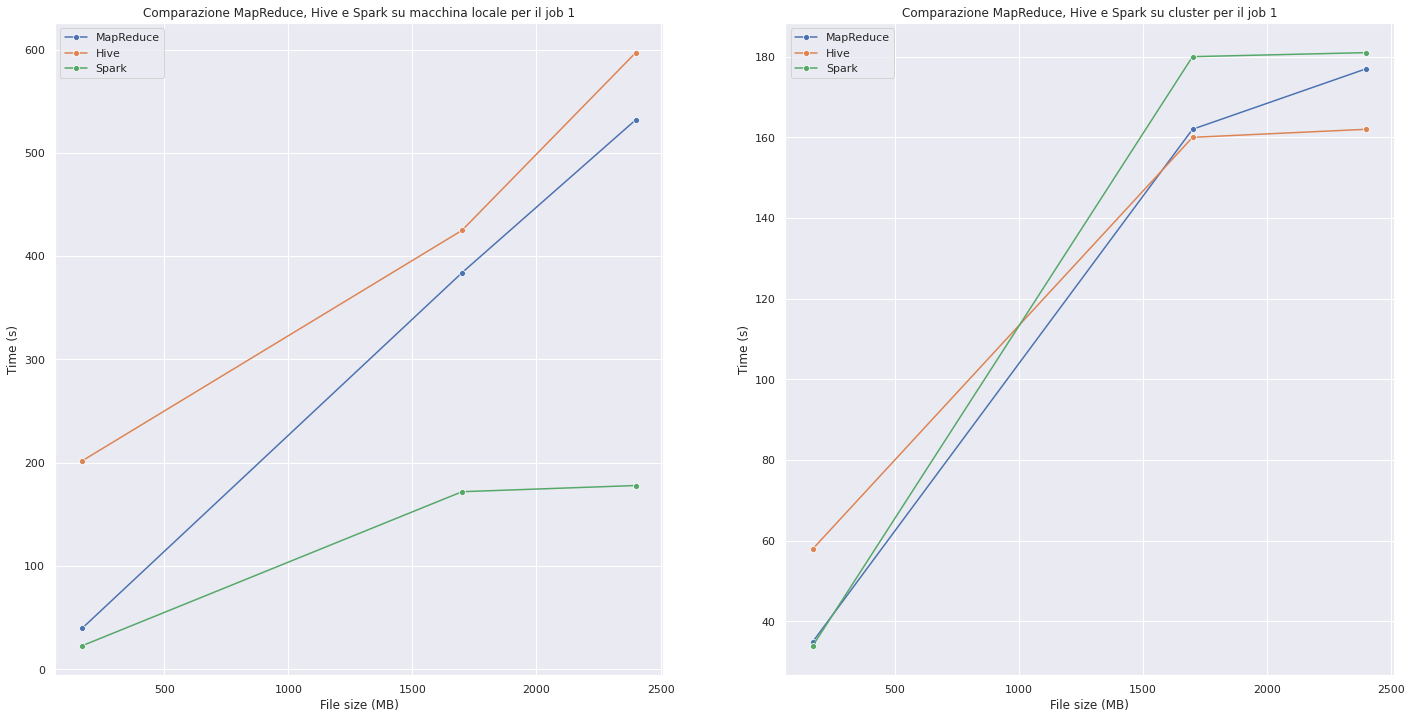

In [ ]:
compareOnLocalMachineAndCluster(1)

#4. Job 2

### Specifiche

Un job che sia in grado di generare un report contenente, per ciascun settore e per ciascun anno del periodo 2009-2018: (a) la variazione percentuale della quotazione del settore 1 nell’anno, (b) l’azione del settore che ha avuto il
maggior incremento percentuale nell’anno (con indicazione dell’incremento) e (c) l’azione del settore che ha avuto il
maggior volume di transazioni nell’anno (con indicazione del volume). Il report deve essere ordinato per nome del
settore.

### Premesse
Nota bene: La seguente premessa è valida sia per il **job 2** che per il **job 3**.

Per entrambi i job va effettuato un join dei due dataset su ticker, tuttavia nel separare per virgola il dataset relativo ai stock abbiamo riscontrato un problema: erano presenti virgole in vari campi testuali.
In **MapReduce** e **Spark Core** ciò è stato risolto con una funzione *my_split(line)*, riportata sotto:



```python
def my_split(line):
    row = line.split(",")
    result = []
    temp = []
    for x in row:
        if "\"" in x:
            temp.append(x)
        else:
            result.append(x)
            temp.clear()

        if len(temp) == 2:
            a = temp[0] + temp[1]
            a = a.replace('\"', '', 2)
            result.append(a)
            temp.clear()
    return result

```

In Hive è stato risolto preprocessando il dataset modificando il separatore da ‘,’
a ‘|’.


## 4.1 Implementazione MapReduce

### Mapper

Il mapper viene richiamato su entrambi i dataset, ovvero **stock_prices** e **stocks**. Dal momento che il numero dei campi dei record è diverso per i due dataset possiamo facilmente riconoscere a quale dataset appartiene il record con un if che controlla la lunghezza di quest’ultimo.

Per quanto riguarda **stock_prices** vengono selezionati i campi  ticker, open, close, volume, date dei soli record le cui date sono comprese negli anni 2009 e 2018 estremi inclusi.


Invece per il dataset **stocks** vengono selezionati i campi ticker e sector solamente se quest’ultimo non è nullo.

È fondamentale che per entrambi i casi venga scelta come chiave il campo ticker di modo da avere i record con la stessa chiave anche se provenienti da diversi dataset sullo stesso reduce task.


```python
class Mapper:

  map(key, record):
        # record relativo a stock_prices
        if len(record) == 7:
          ticker, open, close, _ , _ , volume, date = record
          year = get_year(date)
          if (year < 2009) | (year > 2018):
              continue    
          key = ticker 
          value = date, open, close, volume
          Emit(key, value)
        # record relativo a stocks
        else:
          ticker, _, _, sector, _ = record
          if sector =='N/A':
            continue
          key = ticker
          value = sector
          emit(key, value)

```

### Reducer

Il reducer, per ogni coppia ticker, anno, trova il record più vecchio  (*ticker_anno_2_first_date*) e quello più recente (*ticker_anno_2_last_date*) e i valori di close associati ad essi, utilizzandoli per il calcolo dell’incremento percentuale (*var*) che il ticker ha ottenuto nell’anno e selezionando il ticker che ha avuto il massimo incremento (*sector_anno_2_ticker_max_var*) tramite in un’apposita condizione *if (var > var_max)*.

I valori di close più vecchio e più recente vengono poi utilizzati per calcolare l’incremento percentuale (*sector_anno_2_incremento*) che il settore ha ottenuto nell’anno (sommando precedentemente tutti i valori di close alla minima data (*sector_anno_2_first_close*) e massima data (*sector_anno_2_first_close*), raggruppando per settore, anno).

Viene calcolato inoltre per ogni coppia settore, anno il ticker con il massimo volume (*sector_anno_2_ticker_max_volume*) in modo analogo a quanto visto per *sector_anno_2_ticker_max_var*.



```python
class Reducer:

  setup():
    initializes all dictionaries

  reduce(key, record):
    # record relativo a stock_prices
    if len(key concat record) == 5:
      ticker = key 
      date, open, close, volume = record
      year = get_year(date)
      ticker_anno_2_first_date[(ticker, year)] = min(ticker_anno_2_first_date[(ticker, year)], date)
      ticker_anno_2_last_date[(ticker, year)] = max(ticker_anno_2_last_date[(ticker, year)], date)
  
      ticker_anno_2_first_close[(ticker, year)] = close where ticker__anno_2_first_date[(ticker, year)] == date
      ticker_anno_2_last_close[(ticker, year)] = close where ticker__anno_2_last_date[(ticker, year)] == date
      ticker_anno_2_sum_volume[(ticker, year)] += volume
     # record relativo a stocks
    else:
        ticker, sector = key, record
        ticker_2_sector[ticker] = sector

  print_result():
    for ticker, year in ticker_anno_2_first_close:
            sector = ticker_2_sector[ticker]
            sector_anno_2_first_close[(sector, year)] += ticker_anno_2_first_close[(ticker, year)]
            sector_anno_2_last_close[(sector, year)] += ticker_anno_2_last_close[(ticker, year)]

            _, var_max = sector_anno_2_ticker_max_var[(sector, year)]
            var =  ((ticker_anno_2_last_close[(ticker, year)] - ticker_anno_2_first_close[(ticker, year)]) / ticker_anno_2_first_close[(ticker, year)]) * 100
            if var > var_max:
                sector_anno_2_ticker_max_var[(sector, year)] = (ticker, var)
            
            _, max_volume = sector_anno_2_ticker_max_volume[(sector, year)]
            if ticker_anno_2_sum_volume[(ticker, year)] > max_volume:
                sector_anno_2_ticker_max_volume[(sector, year)] = (ticker, ticker_anno_2_sum_volume[(ticker, year)])

    for sector, year in sector_anno_2_first_close:
        inc = ((sector_anno_2_last_close[(sector, year)] - sector_anno_2_first_close[(sector, year)]) / sector_anno_2_first_close[(sector, year)]) * 100
        sector_anno_2_incremento[(sector, year)] = inc

    for sector, year in sorted(sector_anno_2_incremento):
        ticker_best_var, var = sector_anno_2_ticker_max_var[(sector, year)]
        ticker_best_volume, volume = sector_anno_2_ticker_max_volume[(sector, year)]
        inc = sector_anno_2_incremento[(sector, year)]
        row = sector, year, inc, ticker_best_var, var, ticker_best_volume, volume
        Emit(first_ten_rows)
```

##4.2 Implementazione Hive

I dati vengono aggregati per settore, anno, ticker per calcolarne la data minima , la massima e la somma dei volumi (*sector_anno_ticker_min_max_data_volume*).

Vengono calcolate le variazioni dei ticker in modo analogo al **job 1** e viene trovato il ticker con la massima variazione per ogni settore, anno (*sector_anno_ticker_max_inc)*.
In particolare si noti come nella tabella *sector_anno_ticker_max_inc* il calcolo del massimo con relativo raggruppamento per settore e anno viene effettuato nella select più interna. Il join esterno invece serve a recuperare il nome del ticker a cui è associata la massima variazione.

Viene trovato il ticker con il maggior volume per ogni settore, anno (*sector_anno_ticker_max_vol*).
In modo analogo a come spiegato precedentemente, la tabella sector_anno_ticker_max_vol
usa una select più interna per il calcolo del massimo effettivo e un join esterno per il recupero del ticker associato al massimo volume.

Viene calcolata la variazione del settore nell’anno (*sector_anno_var*), sommando preventivamente i valori di close relativi alla data più vecchia (*sector_anno_min_close*)
 e a quella più recente (*sector_anno_max_close*
).
Il tutto viene ordinato per settore e anno(quest’ultimo non da consegna, ma per garantire una maggiore leggibilità e una maggiore facilità nel confronto degli output)


```sql
DROP TABLE IF EXISTS historical_stock_prices;
DROP TABLE IF EXISTS historical_stocks;
CREATE TABLE historical_stock_prices(ticker STRING, open DOUBLE, close DOUBLE, low DOUBLE, high DOUBLE, volume DOUBLE, data DATE) row format delimited fields terminated by ',';
CREATE TABLE historical_stocks(ticker STRING, variabile_inutile STRING, name STRING, sector STRING, industry STRING) row format delimited fields terminated by '|';

LOAD DATA LOCAL INPATH '/home/alessandro/historical_stock_prices_sampled.csv' OVERWRITE INTO TABLE historical_stock_prices;
LOAD DATA LOCAL INPATH '/home/alessandro/historical_stocks_hive.csv' OVERWRITE INTO TABLE historical_stocks;

DROP TABLE IF EXISTS sector_anno_ticker_min_max_data_volume;
DROP TABLE IF EXISTS sector_anno_min_close;
DROP TABLE IF EXISTS sector_anno_max_close;
DROP TABLE IF EXISTS ticker_percentuale;
DROP TABLE IF EXISTS ticker_min_close;
DROP TABLE IF EXISTS ticker_max_close;
DROP TABLE IF EXISTS sector_anno_var;
DROP TABLE IF EXISTS sector_anno_ticker_max_inc;
DROP TABLE IF EXISTS sector_anno_ticker_max_vol;
DROP TABLE IF EXISTS solution;

CREATE TABLE IF NOT EXISTS sector_anno_ticker_min_max_data_volume AS
SELECT sector, YEAR(data) AS anno, p.ticker, MIN(data) AS min_data, MAX(data) AS max_data, SUM(volume) AS sum_volume
FROM historical_stock_prices as p, historical_stocks as s
WHERE p.ticker = s.ticker
GROUP BY sector, YEAR(data), p.ticker
HAVING (anno >= 2009 AND anno <= 2018) AND sector <> "";

CREATE TABLE IF NOT EXISTS sector_anno_min_close AS
SELECT t.sector, t.anno, SUM(h.close) AS sum_close
FROM sector_anno_ticker_min_max_data_volume AS t, historical_stock_prices AS h
WHERE h.ticker = t.ticker AND h.data = t.min_data
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS sector_anno_max_close AS
SELECT t.sector, t.anno, SUM(h.close) AS sum_close
FROM sector_anno_ticker_min_max_data_volume AS t, historical_stock_prices AS h
WHERE h.ticker = t.ticker AND h.data = t.max_data
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS sector_anno_var AS
SELECT tmin.sector, tmin.anno, (((tmax.sum_close - tmin.sum_close)/tmin.sum_close) * 100) AS var
FROM sector_anno_max_close AS tmax JOIN sector_anno_min_close AS tmin ON tmax.sector = tmin.sector AND tmax.anno = tmin.anno;

CREATE TABLE IF NOT EXISTS ticker_max_close AS
SELECT t.sector, t.anno, t.ticker, h.close
FROM sector_anno_ticker_min_max_data_volume AS t, historical_stock_prices AS h
WHERE h.ticker = t.ticker AND h.data = t.max_data;

CREATE TABLE IF NOT EXISTS ticker_min_close AS
SELECT t.sector, t.anno, h.ticker,  h.close
FROM sector_anno_ticker_min_max_data_volume AS t, historical_stock_prices AS h
WHERE h.ticker = t.ticker AND h.data = t.min_data;

CREATE TABLE IF NOT EXISTS ticker_percentuale AS
SELECT tmin.sector, tmin.anno, tmin.ticker, (((tmax.close - tmin.close)/tmin.close) * 100) AS inc_perc
FROM ticker_min_close AS tmin JOIN ticker_max_close AS tmax on tmax.ticker = tmin.ticker AND tmax.anno = tmin.anno AND tmax.sector = tmin.sector;

CREATE TABLE IF NOT EXISTS sector_anno_ticker_max_inc AS
SELECT  t1.sector, t1.anno, t2.ticker, max_inc_perc
FROM (
    SELECT sector, anno, MAX(inc_perc) AS max_inc_perc
    FROM ticker_percentuale
    GROUP BY sector, anno) AS t1
JOIN ticker_percentuale AS t2 ON t1.max_inc_perc = t2.inc_perc;

CREATE TABLE IF NOT EXISTS sector_anno_ticker_max_vol AS
SELECT  t1.sector, t1.anno, t2.ticker, max_volume
FROM (
    SELECT sector, anno, MAX(sum_volume) as max_volume
    FROM sector_anno_ticker_min_max_data_volume
    GROUP BY sector, anno) AS t1
JOIN sector_anno_ticker_min_max_data_volume AS t2 ON t1.max_volume = t2.sum_volume;

CREATE TABLE IF NOT EXISTS solution AS
SELECT DISTINCT t1.sector, t1.anno, t1.var AS variazione, t2.ticker AS ticker_max_inc, t2.max_inc_perc, t3.ticker AS ticker_max_vol ,t3.max_volume
FROM sector_anno_var AS t1 JOIN sector_anno_ticker_max_inc AS t2 ON t1.sector = t2.sector AND t1.anno = t2.anno
JOIN sector_anno_ticker_max_vol AS t3 ON t2.sector = t3.sector AND t2.anno = t3.anno
ORDER BY sector ASC, anno ASC
LIMIT 10;
```



##4.3 Implementazione Spark Core

Anzitutto il dataset **stocks** viene filtrato per il range di date 2009-2018 (estremi inclusi).

I record vengono aggregati per ticker, sector, anno, trovando per ciascuno di essi il giorno più vecchio e quello più recente e i relativi close. 

Con una successiva aggregazione su sector e anno si sommano i close ottenendo gli RDD *max_data_close* e *min_data_close*.
A questo punto si effettua un join (*join_min_con_max*)  tra i due RDD in modo da calcolare l’incremento percentuale (*incremento*).

Vengono calcolate le variazioni dei ticker in modo analogo al **job 1** e viene trovato il ticker con la massima variazione per ogni settore, anno (*incremento_ticker*).

In modo simile viene calcolato il massimo volume per settore e anno (*ticker_volume*).
Nello specifico si sommano i volumi aggregando per ticker e anno, poi si trova il massimo raggruppando per sector e anno.


```python
input_prices_RDD = sparkContext.textFile(input_path_prices).cache().map(line -> line.split(",")) \
    .filter(line -> line[TICKER] != "ticker")
input_stocks_RDD = sparkContext.textFile(input_path_stocks).cache().map(line -> split_for_historical_stocks(line)) \
    .filter(line -> line[TICKER] != "ticker") & (line[SECTOR] != "N/A")))

df_stocks = input_stocks_RDD.map(line -> (line[TICKER], line[SECTOR]))
df_prices = input_prices_RDD.filter(line -> ((line[DATE].get_year() >= '2009') & (line[DATE].get_year() <= '2018'))) \
    .map(line -> (line[TICKER], (line[CLOSE], line[VOLUME], line[DATE])))
join_prices_con_stocks = df_prices.join(df_stocks)

join_prices_con_stocks = join_prices_con_stocks.map(line -> (line[TICKER], line[SECTOR], line[DATE].get_year(), line[CLOSE], line[DATE], line[VOLUME]))


min_data_close = join_prices_con_stocks \
    .map(line -> ((line[TICKER], line[SECTOR], line[YEAR]), (line[CLOSE], line[DATE]))) \
    .reduceByKey(x, y -> close_min_data(x, y)) \
    .map(lambda line -> ((line[SECTOR], line[YEAR]), line[CLOSE])) \
    .reduceByKey(x, y: x + y)


max_data_close = join_prices_con_stocks \
    .map(line -> ((line[TICKER], line[SECTOR], line[YEAR]), (line[CLOSE], line[DATE]))\
    .reduceByKey(x, y -> close_max_data(x, y)) \
    .map(line -> ((line[SECTOR], line[YEAR]), line[CLOSE])) \
    .reduceByKey(x, y -> x + y)

join_min_con_max = min_data_close.join(max_data_close)
incremento = join_min_con_max.map(line -> ((line[SECTOR], line[ANNO]), ((line[CLOSE_MAX_DATA] - line[CLOSE_MIN_DATA]) / line[CLOSE_MIN_DATA]) * 100))


max_data_close_ticker = join_prices_con_stocks \
    .map(line: ((line[TICKER], line[YEAR]), (line[CLOSE], line[DATE], line[SECTOR]))) \
    .reduceByKey(x, y -> close_max_data(x, y))\
    .map(line -> ((line[TICKER], line[YEAR]), (line[CLOSE], line[SECTOR])))

min_data_close_ticker = join_hsp_hs \
    .map(line: (line[TICKER], line[YEAR]), (line[CLOSE], line[DATE], line[SECTOR])) \
    .reduceByKey(x, y -> close_min_data(x, y)) \
    .map(line -> ((line[TICKER], line[YEAR]), (line[CLOSE], line[SECTOR])))

ticker_volume = join_prices_con_stocks.map(line -> ((line[TICKER], line[YEAR]), (line[VOLUME], line[SECTOR]))) \
    .reduceByKey(x, y: (x[VOLUME] + y[VOLUME], x[SECTOR])) \
    .map(line -> ((line[SECTOR], line[YEAR]), (line[TICKER], line[VOLUME])))\
    .reduceByKey(x, y: max_volume(x, y))

join_incremento_ticker = min_data_close_ticker.join(max_data_close_ticker)
incremento_ticker = join_incremento_ticker\
    .map(line -> ((line[SECTOR], line[YEAR]), (line[TICKER], ((line[CLOSE_MAX_DTA] - line[CLOSE_MIN_DATA]) / line[CLOSE_MIN_DATA]) * 100 ))) \
    .reduceByKey(x, y: max_incremento(x, y))

result = incremento.join(incremento_ticker).join(ticker_volume)\
    .map(line: (line[SECTOR], line[YEAR], line[INCREMENTO_SETTORE], line[TICKER_CON_MAX_INCREMENTO], line[MAX_INCREMENTO_TICKER], line[TICKER_CON_MAX_VOLUME], line[MAX_VOLUME_TICKER]))\
    .sortBy(line[SECTOR])\
    .take(10)
sparkContext.parallelize(result).coalesce(1).saveAsTextFile(output_filepath)


```

## 4.4 Output

Output relativo al dataset originale ripulito dai record non coerenti e inconsistenti.

### MapReduce
```
BASIC INDUSTRIES	2009	3.482876	GURE	709.722222	FCX	9141685400	
BASIC INDUSTRIES	2010	21.790036	BLD	519.801980	FCX	6891808600	
BASIC INDUSTRIES	2011	-58.600764	ROAD	188.704319	FCX	5150807800	
BASIC INDUSTRIES	2012	-68.788525	PATK	261.860457	VALE	4659766700	
BASIC INDUSTRIES	2013	10.322636	XRM	416.927900	VALE	4428233700	
BASIC INDUSTRIES	2014	-71.902133	BLD	884.600000	VALE	5660183200	
BASIC INDUSTRIES	2015	-48.101172	SUM	35191.630357	FCX	7286761300	
BASIC INDUSTRIES	2016	13.829358	TECK	451.790661	FCX	10464699500	
BASIC INDUSTRIES	2017	15.279011	OPNT	310.178554	VALE	7023267600	
BASIC INDUSTRIES	2018	-3.079521	XRM	213.817330	VALE	3710091900	

```

### Hive


```
BASIC INDUSTRIES || 2009 || 3.482875789517992 || GURE || 709.7221794503712 || FCX || 9.1416854E9
BASIC INDUSTRIES || 2010 || 21.790035560716724 || BLD || 519.8020087119551 || FCX || 6.8918086E9
BASIC INDUSTRIES || 2011 || -58.60076361670825 || ROAD || 188.7043257130473 || FCX || 5.1508078E9
BASIC INDUSTRIES || 2012 || -68.78852489683118 || PATK || 261.86046001007276 || VALE || 4.6597667E9
BASIC INDUSTRIES || 2013 || 10.322636195480321 || XRM || 416.92788323917506 || VALE || 4.4282337E9
BASIC INDUSTRIES || 2014 || -71.90213258565299 || BLD || 884.59997177124 || VALE || 5.6601832E9
BASIC INDUSTRIES || 2015 || -48.10117196333272 || SUM || 35191.62979183738 || FCX || 7.2867613E9
BASIC INDUSTRIES || 2016 || 13.829357749181595 || TECK || 451.79063512868385 || FCX || 1.04646995E10
BASIC INDUSTRIES || 2017 || 15.279010761476975 || OPNT || 310.1785661523438 || VALE || 7.0232676E9
BASIC INDUSTRIES || 2018 || -3.0795214895223917 || XRM || 213.81732267883416 || VALE || 3.7100919E9

```
### Spark Core
```
('BASIC INDUSTRIES', '2009', 3.482875789517992, 'GURE', 709.7221794503712, 'FCX', 9141685400.0)
('BASIC INDUSTRIES', '2010', 21.790035560716724, 'BLD', 519.8020087119551, 'FCX', 6891808600.0)
('BASIC INDUSTRIES', '2011', -58.60076361670825, 'ROAD', 188.7043257130473, 'FCX', 5150807800.0)
('BASIC INDUSTRIES', '2012', -68.78852489683118, 'PATK', 261.86046001007276, 'VALE', 4659766700.0)
('BASIC INDUSTRIES', '2013', 10.322636195480321, 'XRM', 416.92788323917506, 'VALE', 4428233700.0)
('BASIC INDUSTRIES', '2014', -71.90213258565299, 'BLD', 884.59997177124, 'VALE', 5660183200.0)
('BASIC INDUSTRIES', '2015', -48.10117196333272, 'SUM', 35191.62979183738, 'FCX', 7286761300.0)
('BASIC INDUSTRIES', '2016', 13.829357749181595, 'TECK', 451.79063512868385, 'FCX', 10464699500.0)
('BASIC INDUSTRIES', '2017', 15.279010761476977, 'OPNT', 310.1785661523438, 'VALE', 7023267600.0)
('BASIC INDUSTRIES', '2018', -3.079521489522374, 'XRM', 213.81732267883416, 'VALE', 3710091900.0)

```

##4.5 Grafici

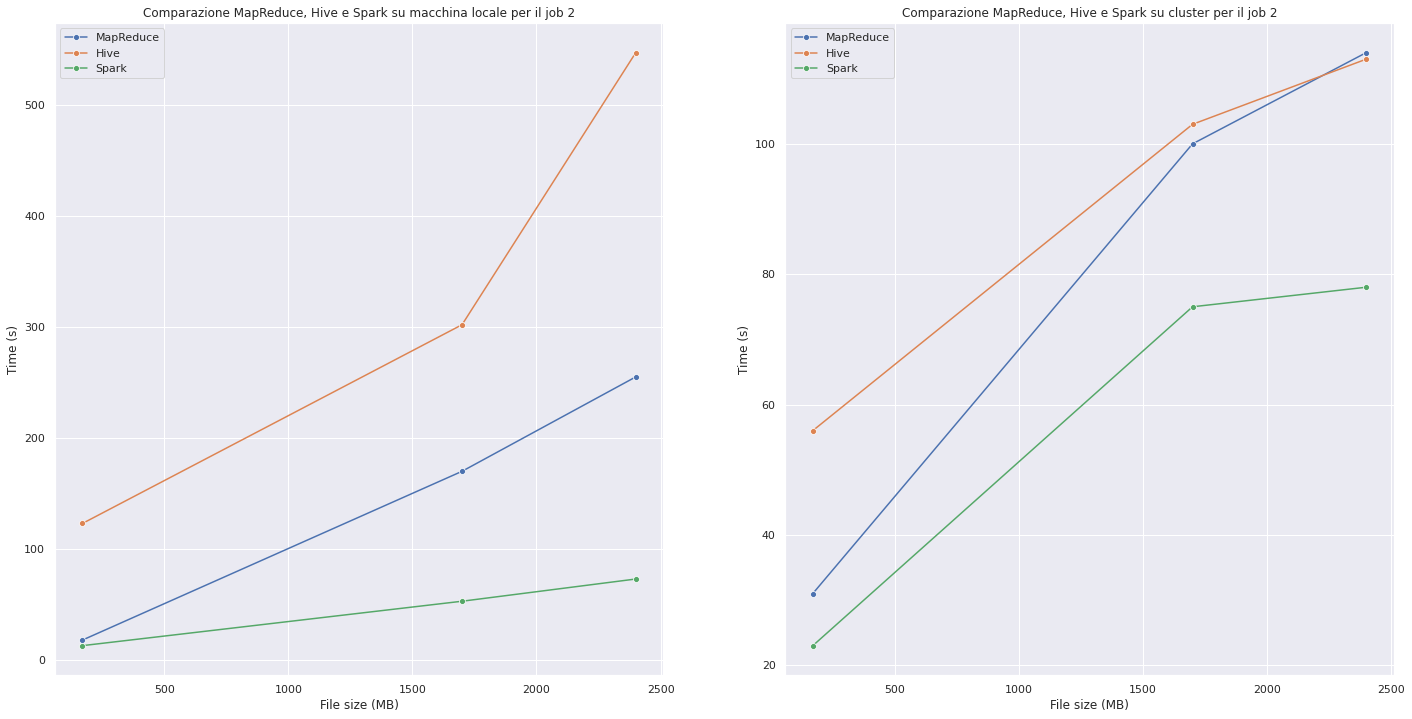

In [ ]:
compareOnLocalMachineAndCluster(2)

#5. Job 3

### Specifiche

Un job in grado di generare le coppie di aziende che si somigliano (sulla base di una soglia scelta a piacere) in termini di
variazione percentuale mensile nell’anno 2017 mostrando l’andamento mensile delle due aziende (es. Soglia=1%,
coppie: 1:{Apple, Intel}: GEN: Apple +2%, Intel +2,5%, FEB: Apple +3%, Intel +2,7%, MAR: Apple +0,5%, Intel +1,2%, ...;
2:{Amazon, IBM}: GEN: Amazon +1%, IBM +0,5%, FEB: Amazon +0,7%, IBM +0,5%, MAR: Amazon +1,4%, IBM +0,7%, ..)

### Premesse

Si veda il capitolo riguardo il **job 2** dove è specificata una premessa valida anche per il **job 3**.

##5.1 Implementazione MapReduce

###Mapper


Il mapper viene richiamato su entrambi i dataset, ovvero **stock_prices** e **stocks**. Dal momento che il numero dei campi dei record è diverso per i due dataset possiamo facilmente riconoscere a quale dataset appartiene il record con un if che controlla la lunghezza di quest’ultimo.
Per quanto riguarda **stock_prices** vengono selezionati i campi ticker, month (estrapolato da date), day (estrapolato da date), close, dei soli record le cui date hanno anno pari a 2017.
Invece per il dataset stocks vengono selezionati i campi ticker e name.
È fondamentale che per entrambi i casi venga scelta come chiave il campo ticker di modo da avere i record con la stessa chiave anche se provenienti da diversi dataset sullo stesso reduce task.


```python
class Mapper:

  map(key, record):
    # record relativo a stock_prices
    if len(record) == 7:
      ticker, _, close, _ , _ , _, date = record
      year = get_year(date)
      month = get_month(date)
      day = get_day(date) 
      if year != 2017:
          continue    
      key = ticker 
      value = month, day, close
      Emit(key, value)
    # record relativo a stocks
    else:
      ticker, _, name, _, _ = record
      key = ticker
      value = name
      emit(key, value)

```

###Reducer
Il reducer, per ogni coppia ticker, month trova il record più vecchio (*ticker_month_2_first_day*) e quello più recente (*ticker_month_2_last_day*) e i valori di close associati ad essi.
I valori di close più vecchio e più recente vengono poi utilizzati per calcolare l’incremento percentuale (*name_month_2_incremento*) che l’azienda ha ottenuto nel mese (sommando precedentemente tutti i valori di close alla minima data (*ticker_month_2_first_close*) e massima data (*ticker_month_2_last_close*), raggruppando per name, month).
Infine vengono generate tutte le coppie di aziende le cui differenze di variazioni mensili sono minori o uguali alla soglia (nel nostro caso soglia = 1%).



```python

class Reducer:
  
  setup():
    initializes all dictionaries

  reduce(key, record)
    if len(key concat record) == 4:
      ticker = key
      month, day, close = record

      ticker_month_2_first_day[(ticker,month)] = min(ticker_2_first_date[(ticker,month)], date)
      ticker_month_2_last_day[ticker] = max(ticker_month_2_last_day[ticker], date)

      ticker_month_2_first_close[(ticker, month)] = close where ticker_month_2_first_day[(ticker,month)] == day
      ticker_month_2_last_close[(ticker, month)] = close where ticker_month_2_last_day[(ticker,month)] == day

    else:
        ticker, name = row
        ticker_2_name[ticker] = name

print_result():
  
  for ticker, month in ticker_month_2_first_close:
      name = ticker_2_name[ticker]
      name_month_2_first_close[(name, month)] += ticker_month_2_first_close[(ticker, month)]
      name_month_2_last_close[(name, month)] += ticker_month_2_last_close[(ticker, month)]

  for name, month in name_month_2_first_close:
      var = ((name_month_2_last_close[(name, month)] - name_month_2_first_close[(name, month)]) / name_month_2_first_close[(name, month)]) * 100
      name_month_2_variation[(name, month)] = var


  names_list = ticker_2_name.unique_values()
  add = True
  for i in range(len(names_list)):
      for j in range(i+1, len(names_list)):
          add = True
          n1, n2 = names_list[i], names_list[j]
          for m in months:
              if ((n1, m) not in name_month_2_variation) | ((n2, m) not in name_month_2_variation):
                  add = False
                  break
              if (abs(name_month_2_variation[(n1, m)] - name_month_2_variation[(n2, m)])) > SOGLIA:
                  add = False
                  break
          if add:
              coppie.append((n1, n2))

  coppie = sorted(coppie)
  coppie_first_10 = coppie[:10]
  for n1, n2 in coppie_first_10:
    emit(n1, n2)
      for m in months:
        emit(name_month_2_variation[n1,m], name_month_2_variation[n2,m])

```

##5.2 Implementazione Hive

I dati vengono aggregati per nome, mese, ticker per calcolarne la data minima e la massima (*nome_ticker_mese_min_max_data*).

Viene calcolata la variazione dell'azienda nell’anno (*nome_mese_var*), sommando preventivamente i valori di close relativi alla data più vecchia (*nome_mese_max_close*) e a quella più recente (*nome_mese_max_close*). Il tutto viene ordinato per nome e mese (quest’ultimo non da consegna, ma per garantire una maggiore leggibilità e una maggiore facilità nel confronto degli output).

A questo punto si effettua un "prodotto cartesiano" per generare tutte le possibili coppie di aziende (*coppia_nome_mese*). Si noti come nella tabella *coppia_nome_mese* sia espressa la condizione sulla soglia e quella per evitare i duplicati nella stessa riga. Si specifica inoltre che il join è stato fatto solamente in caso le due righe abbiano lo stesso mese.

Successivamente si contano il numero di mesi raggrupando per *name1* e *name2* (*coppia_nome_count_mesi*).

La soluzione è generata facendo un join delle tabelle *coppia_nome_mese* e *coppia_nome_count_mesi*. La condizione ci permette di selezionare solamente le righe che hanno 12 mesi, inoltre grazie alla clausola *t1.name2 < t2.name1* è possibile eliminare i record doppi che hanno la stessa chiave ma con ordine inverso. Per concludere con una aggregazione finale si mettono tutti i mesi sulla stessa riga facendo uso della funzione *collect_list*.

```sql

DROP TABLE IF EXISTS historical_stock_prices;
DROP TABLE IF EXISTS historical_stocks;
CREATE TABLE historical_stock_prices(ticker STRING, open DOUBLE, close DOUBLE, low DOUBLE, high DOUBLE, volume DOUBLE, data DATE) row format delimited fields terminated by ',';
CREATE TABLE historical_stocks(ticker STRING, variabile_inutile STRING, name STRING, sector STRING, industry STRING) row format delimited fields terminated by '|';


LOAD DATA LOCAL INPATH '/home/alessandro/historical_stock_prices_cleaned.csv' OVERWRITE INTO TABLE historical_stock_prices;
LOAD DATA LOCAL INPATH '/home/alessandro/historical_stocks_hive.csv' OVERWRITE INTO TABLE historical_stocks;


DROP TABLE IF EXISTS nome_ticker_mese_min_max_data;
DROP TABLE IF EXISTS nome_mese_min_close;
DROP TABLE IF EXISTS nome_mese_max_close;
DROP VIEW IF EXISTS nome_ticker_mese_var;
DROP TABLE IF EXISTS nome_mese_var;
DROP TABLE IF EXISTS coppia_nome_mese;
DROP TABLE IF EXISTS coppia_nome_count_mesi;
DROP TABLE IF EXISTS the_real_coppia_nome_mese;
DROP TABLE IF EXISTS solution;


CREATE TABLE IF NOT EXISTS nome_ticker_mese_min_max_data AS
SELECT name, p.ticker, MONTH(data) AS mese, MIN(DAY(data)) AS min_giorno, MAX(DAY(data)) AS max_giorno
FROM historical_stock_prices as p, historical_stocks as s
WHERE p.ticker = s.ticker AND YEAR(data) = 2017
GROUP BY name,  p.ticker, MONTH(data);

CREATE TABLE IF NOT EXISTS nome_mese_min_close AS
SELECT t.name, t.mese, SUM(h.close) AS min_close
FROM nome_ticker_mese_min_max_data AS t, historical_stock_prices AS h
WHERE h.ticker = t.ticker AND DAY(h.data) = t.min_giorno AND MONTH(h.data) = t.mese AND YEAR(h.data) = 2017
GROUP BY t.name, t.mese;

CREATE TABLE IF NOT EXISTS nome_mese_max_close AS
SELECT t.name, t.mese, SUM(h.close) AS max_close
FROM nome_ticker_mese_min_max_data AS t, historical_stock_prices AS h
WHERE h.ticker = t.ticker AND DAY(h.data) = t.max_giorno AND MONTH(h.data) = t.mese AND YEAR(h.data) = 2017
GROUP BY t.name, t.mese;

CREATE VIEW IF NOT EXISTS nome_mese_var AS
SELECT tmin.name, tmin.mese, ((tmax.max_close - tmin.min_close)/tmin.min_close) * 100 AS var
FROM nome_mese_max_close AS tmax JOIN nome_mese_min_close AS tmin ON tmax.name = tmin.name AND tmax.mese = tmin.mese;

CREATE TABLE IF NOT EXISTS coppia_nome_mese AS
SELECT t1.name AS name1, t2.name AS name2, t1.mese, t1.var AS var1, t2.var AS var2
FROM nome_mese_var AS t1, nome_mese_var AS t2
WHERE t1.mese = t2.mese AND t1.name <> t2.name AND (ABS( t1.var  - t2.var)) <= 1.0;

CREATE TABLE IF NOT EXISTS coppia_nome_count_mesi AS
SELECT name1, name2, COUNT(mese) AS num_mesi
FROM coppia_nome_mese
GROUP BY name1, name2;

CREATE TABLE IF NOT EXISTS the_real_coppia_nome_mese AS
SELECT t1.name1, t1.name2, t1.mese, t1.var1, t1.var2
FROM coppia_nome_mese AS t1 JOIN coppia_nome_count_mesi AS t2 ON t1.name1 = t2.name1 AND t1.name2 = t2.name2
WHERE t2.num_mesi = 12 AND t1.name2 < t2.name1;

CREATE TABLE IF NOT EXISTS solution AS
SELECT name1, name2, collect_list(concat_ws(';',array(string(mese),string(var1),string(var2))))
FROM the_real_coppia_nome_mese
GROUP BY name1, name2
ORDER BY name1
LIMIT 10;
```



##5.3 Implementazione Spark Core

I record vengono aggregati per ticker e mese, trovando per ciascuno di essi il giorno più vecchio e quello più recente e i relativi close. Con una successiva aggregazione su name e mese si sommano i close ottenendo gli RDD *max_data_close_ticker* e *min_data_close_ticker*.
A questo punto si effettua un join tra i due RDD per poi calcolare l'incremento percentuale per ciascun name e mese (*join_incremento*). Il risultato così ottenuto tramite una reduce è aggregato solamente per name di modo da scrivere su un unica riga la lista delle variazioni percentuali con i relativi mesi. Con successivi passaggi la lista viene ordinata e filtrata eliminando i record che non hanno 12 mesi.

Il risulato finale (*result*) è ottenuto con un prodotto cartesiano utile per generare tutte le possibili coppie *name1* e *name2*. Su queste vengono poi applicati dei filtri per eliminare i duplicati sulla stessa riga, quelli che non rispettano la soglia (tramite la funzione *controllo_soglia* che vuole in input le liste degli incrementi ordinate per mesi) e i duplicati su più righe. In particolare i duplicati su più righe sono stati eliminati prima riordinando le chiavi name1 e name2 di ciascun record con una map e poi usando una *reduceByKey*.


```python
input_prices_RDD = sparkContext.textFile(input_path_prices).cache().map(line -> line.split(",")) \
    .filter(line -> (line[TICKER] != "ticker") & (line[DATE].get_year() == "2017"))
input_stocks_RDD = sparkContext.textFile(input_path_stocks).cache().map(line -> split_for_historical_stocks(line)) \
    .filter(line -> line[TICKER] != "ticker")

df_price = input_prices_RDD.map(line -> (line[TICKER], (line[DATE].get_month()], line[DATE].get_day(), line[CLOSE])))
df_stocks = input_stocks_RDD.map(line -> (line[TICKER], line[NAME]))

join_prices_con_stocks = df_price.join(df_stocks)

join_prices_con_stocks= join_prices_con_stocks.map(line -> ((line[TICKER], line[MESE]), (line[CLOSE], line[DAY], line[NAME])))

max_data_close_ticker = join_prices_con_stocks \
    .reduceByKey(x, y -> close_max_day(x, y)) \
    .map(line -> ((line[NAME], line[MONTH]), line[CLOSE])) \
    .reduceByKey(x, y -> x + y)

min_data_close_ticker = join_prices_con_stocks \
    .reduceByKey(x, y -> close_min_day(x, y)) \
    .map(line -> ((line[NAME], line[MONTH]), line[CLOSE])) \
    .reduceByKey(x, y -> x + y)


join_incremento = min_data_close_ticker.join(max_data_close_ticker) \
    .map(line -> ((line[NAME], line[MONTH]),  ((line[CLOSE_MAX_DAY] - (line[CLOSE_MIN_DAY])) / line[CLOSE_MIN_DAY]) * 100))


nome_2_incremento_mesi = join_incremento \
    .map(line -> ((line[NAME]), [(line[MESE], line[INCREMENTO_MESE])]))\
    .reduceByKey(x, y: x concat y)

nome_2_incremento_mesi = nome_2_incremento_mesi.filter((line[LISTA_INCREMENTO_MESI].length() == 12)) \
    .map(line -> (line[NAME], sort_by_month(line[LISTA_INCREMENTO_MESI])))

result = nome_2_incremento_mesi.cartesian(nome_2_incremento_mesi) \
    .filter(line -> line[NAME1] != line[NAME2]) \
    .filter(line -> controllo_soglia(line[LISTA1_INCREMENTO_MESI], line[LISTA2_INCREMENTO_MESI])) \
    .map(line -> (order_key((line[NAME1], line[NAME2])), print_list(line))) \
    .reduceByKey(x, y -> x) \
    .sortByKey() \
    .take(10)


sparkContext.parallelize(result).coalesce(1).saveAsTextFile(output_filepath)
```

## 5.4 Output

Output relativo al dataset originale ripulito dai record non coerenti e inconsistenti.

### MapReduce
```
AEGON NV, SCUDDER MULTI-MARKET INCOME TRUST, ['JAN: AEGON NV 1.755946%, SCUDDER MULTI-MARKET INCOME TRUST 1.406800% ', 'FEB: AEGON NV 1.803603%, SCUDDER MULTI-MARKET INCOME TRUST 0.923788% ', 'MAR: AEGON NV -0.073789%, SCUDDER MULTI-MARKET INCOME TRUST -0.798176% ', 'APR: AEGON NV 0.036641%, SCUDDER MULTI-MARKET INCOME TRUST 0.919540% ', 'MAY: AEGON NV -0.158228%, SCUDDER MULTI-MARKET INCOME TRUST 0.792752% ', 'JUN: AEGON NV -0.291759%, SCUDDER MULTI-MARKET INCOME TRUST -1.012373% ', 'JUL: AEGON NV 0.937309%, SCUDDER MULTI-MARKET INCOME TRUST 0.339751% ', 'AUG: AEGON NV -0.482565%, SCUDDER MULTI-MARKET INCOME TRUST 0.000000% ', 'SEPT: AEGON NV -0.376032%, SCUDDER MULTI-MARKET INCOME TRUST 0.448430% ', 'OCT: AEGON NV 0.146501%, SCUDDER MULTI-MARKET INCOME TRUST 0.335946% ', 'NOV: AEGON NV 0.256443%, SCUDDER MULTI-MARKET INCOME TRUST 0.223714% ', 'DEC: AEGON NV -0.242539%, SCUDDER MULTI-MARKET INCOME TRUST -0.449944% ']	
ALLIANZGI CONVERTIBLE & INCOME FUND, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II, ['JAN: ALLIANZGI CONVERTIBLE & INCOME FUND 4.225352%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 3.247863% ', 'FEB: ALLIANZGI CONVERTIBLE & INCOME FUND 4.210526%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 3.482587% ', 'MAR: ALLIANZGI CONVERTIBLE & INCOME FUND -2.733813%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -2.707006% ', 'APR: ALLIANZGI CONVERTIBLE & INCOME FUND 2.654867%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 1.967213% ', 'MAY: ALLIANZGI CONVERTIBLE & INCOME FUND -0.286944%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -0.158983% ', 'JUN: ALLIANZGI CONVERTIBLE & INCOME FUND -0.428571%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -0.953895% ', 'JUL: ALLIANZGI CONVERTIBLE & INCOME FUND 2.844950%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 2.551834% ', 'AUG: ALLIANZGI CONVERTIBLE & INCOME FUND -3.443526%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -3.576983% ', 'SEPT: ALLIANZGI CONVERTIBLE & INCOME FUND 1.139601%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 0.160514% ', 'OCT: ALLIANZGI CONVERTIBLE & INCOME FUND -0.559441%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -0.801282% ', 'NOV: ALLIANZGI CONVERTIBLE & INCOME FUND -1.126761%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -1.951220% ', 'DEC: ALLIANZGI CONVERTIBLE & INCOME FUND -0.565771%, ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -0.663350% ']	
BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST, ['JAN: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.534759%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.396040% ', 'FEB: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.464191%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST 0.132450% ', 'MAR: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.532978%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST 0.664011% ', 'APR: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.132626%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST 0.331785% ', 'MAY: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.331345%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.592885% ', 'JUN: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.198544%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.066313% ', 'JUL: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.000000%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.661376% ', 'AUG: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.132626%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.133067% ', 'SEPT: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.066445%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST 0.133156% ', 'OCT: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.066489%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.133156% ', 'NOV: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.932712%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.266489% ', 'DEC: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -3.221477%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -2.738811% ']	
BLACKROCK MUNICIPAL 2018 TERM TRUST, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND, ['JAN: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.734312%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.467858% ', 'FEB: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.396825%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.040496% ', 'MAR: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.132626%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.344832% ', 'APR: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066401%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -0.201780% ', 'MAY: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133067%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.000000% ', 'JUN: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.000000%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -0.485145% ', 'JUL: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133245%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.264069% ', 'AUG: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066534%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.202425% ', 'SEPT: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066489%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -0.020214% ', 'OCT: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.199734%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.222539% ', 'NOV: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.266845%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -0.060590% ', 'DEC: BLACKROCK MUNICIPAL 2018 TERM TRUST -1.336005%, VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -1.413570% ']	
BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC., NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL, ['JAN: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. 1.728201%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL 1.329163% ', 'FEB: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. 0.386698%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL 0.000000% ', 'MAR: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. -0.230947%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL 0.464396% ', 'APR: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. 0.539291%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL 0.691244% ', 'MAY: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. 0.689655%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL 0.381098% ', 'JUN: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. -0.838415%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL -0.681818% ', 'JUL: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. 1.220442%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL 1.367781% ', 'AUG: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. 0.075245%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL 0.149813% ', 'SEPT: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. -0.975976%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL -1.712584% ', 'OCT: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. -1.739788%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL -1.669196% ', 'NOV: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. -0.077042%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL -0.385208% ', 'DEC: BLACKROCK MUNIYIELD NEW YORK QUALITY FUND INC. -0.615385%, NUVEEN NEW YORK AMT-FREE QUALITY MUNICIPAL -0.154083% ']	
BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST, BLACKROCK MUNICIPAL 2018 TERM TRUST, ['JAN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.337838%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.734312% ', 'FEB: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.267917%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.396825% ', 'MAR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.667557%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.132626% ', 'APR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.538721%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066401% ', 'MAY: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.000000%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133067% ', 'JUN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.403226%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.000000% ', 'JUL: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.066934%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133245% ', 'AUG: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.134228%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066534% ', 'SEPT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.336247%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066489% ', 'OCT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.534045%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.199734% ', 'NOV: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.402145%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.266845% ', 'DEC: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.809717%, BLACKROCK MUNICIPAL 2018 TERM TRUST -1.336005% ']	
BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST, FIRST TRUST ENHANCED SHORT MATURITY ETF, ['JAN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.337838%, FIRST TRUST ENHANCED SHORT MATURITY ETF 0.033383% ', 'FEB: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.267917%, FIRST TRUST ENHANCED SHORT MATURITY ETF 0.083431% ', 'MAR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.667557%, FIRST TRUST ENHANCED SHORT MATURITY ETF -0.016671% ', 'APR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.538721%, FIRST TRUST ENHANCED SHORT MATURITY ETF 0.000000% ', 'MAY: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.000000%, FIRST TRUST ENHANCED SHORT MATURITY ETF -0.016673% ', 'JUN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.403226%, FIRST TRUST ENHANCED SHORT MATURITY ETF 0.008330% ', 'JUL: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.066934%, FIRST TRUST ENHANCED SHORT MATURITY ETF 0.016663% ', 'AUG: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.134228%, FIRST TRUST ENHANCED SHORT MATURITY ETF 0.016663% ', 'SEPT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.336247%, FIRST TRUST ENHANCED SHORT MATURITY ETF 0.000000% ', 'OCT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.534045%, FIRST TRUST ENHANCED SHORT MATURITY ETF 0.049998% ', 'NOV: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.402145%, FIRST TRUST ENHANCED SHORT MATURITY ETF -0.016657% ', 'DEC: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.809717%, FIRST TRUST ENHANCED SHORT MATURITY ETF -0.049988% ']	
BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST, FIRST TRUST LOW DURATION OPPORTUNITIES ETF, ['JAN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.337838%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.153114% ', 'FEB: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.267917%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF 0.249524% ', 'MAR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.667557%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.287360% ', 'APR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.538721%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.019183% ', 'MAY: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.000000%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF 0.019190% ', 'JUN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.403226%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.063293% ', 'JUL: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.066934%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF 0.057587% ', 'AUG: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.134228%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.057591% ', 'SEPT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.336247%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.153635% ', 'OCT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.534045%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.307751% ', 'NOV: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.402145%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.212111% ', 'DEC: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.809717%, FIRST TRUST LOW DURATION OPPORTUNITIES ETF -0.289635% ']	
BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST, ISHARES 1-3 YEAR TREASURY BOND ETF, ['JAN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.337838%, ISHARES 1-3 YEAR TREASURY BOND ETF 0.189623% ', 'FEB: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.267917%, ISHARES 1-3 YEAR TREASURY BOND ETF 0.071037% ', 'MAR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.667557%, ISHARES 1-3 YEAR TREASURY BOND ETF 0.142174% ', 'APR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.538721%, ISHARES 1-3 YEAR TREASURY BOND ETF 0.094632% ', 'MAY: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.000000%, ISHARES 1-3 YEAR TREASURY BOND ETF 0.142015% ', 'JUN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.403226%, ISHARES 1-3 YEAR TREASURY BOND ETF -0.059147% ', 'JUL: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.066934%, ISHARES 1-3 YEAR TREASURY BOND ETF 0.260788% ', 'AUG: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.134228%, ISHARES 1-3 YEAR TREASURY BOND ETF 0.165601% ', 'SEPT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.336247%, ISHARES 1-3 YEAR TREASURY BOND ETF -0.165503% ', 'OCT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.534045%, ISHARES 1-3 YEAR TREASURY BOND ETF -0.165797% ', 'NOV: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.402145%, ISHARES 1-3 YEAR TREASURY BOND ETF -0.201874% ', 'DEC: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.809717%, ISHARES 1-3 YEAR TREASURY BOND ETF -0.154805% ']	
BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST, ISHARES CORE 1-5 YEAR USD BOND ETF, ['JAN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.337838%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.320126% ', 'FEB: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.267917%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.299636% ', 'MAR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.667557%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.159868% ', 'APR: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.538721%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.319170% ', 'MAY: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.000000%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.398726% ', 'JUN: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.403226%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.039801% ', 'JUL: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.066934%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.379094% ', 'AUG: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.134228%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.278383% ', 'SEPT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.336247%, ISHARES CORE 1-5 YEAR USD BOND ETF -0.119217% ', 'OCT: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.534045%, ISHARES CORE 1-5 YEAR USD BOND ETF 0.039872% ', 'NOV: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.402145%, ISHARES CORE 1-5 YEAR USD BOND ETF -0.239814% ', 'DEC: BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.809717%, ISHARES CORE 1-5 YEAR USD BOND ETF -0.040112% ']	

```
### Hive
```
ALLIANZGI CONVERTIBLE & INCOME FUND ||  ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II || 5;-0.28694378089731737;-0.1589785708318904 | 12;-0.5657703095024171;-0.6633571691278668 | 8;-3.4435260622368347;-3.5769832848177274 | 1;4.225351902472054;3.24786427893784 | 6;-0.42857442583356586;-0.953894167621969 | 9;1.139600055889208;0.16050966314696363 | 2;4.210522239935708;3.4825796683759203 | 10;-0.5594400184546108;-0.801277495699989 | 3;-2.733806987016156;-2.7070074938602087 | 7;2.8449474153087206;2.551831704925576 | 11;-1.1267595039524292;-1.9512176211098096 | 4;2.6548646426031373;1.9672112694288226
BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST || BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST || 4;0.13262903093360015;0.33178627569628555 | 11;-0.9327137987201216;-0.26648874912095055 | 10;-0.06649088369126638;-0.13315883591308728 | 3;0.5329774982425756;0.6640068061694412 | 6;-0.19854224786722746;-0.06631451546747741 | 9;-0.06644670269211185;0.1331524865497898 | 2;-0.464188960069286;0.13244704360366066 | 7;0.0;-0.6613718819595202 | 1;0.5347588469385491;-0.39603608879972446 | 8;-0.13262270683411598;-0.13306390182779138 | 5;0.33134652239435164;-0.5928863687651881 | 12;-3.2214735203043374;-2.7388098870988045
BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST || BLACKROCK MUNICIPAL 2018 TERM TRUST || 1;0.33783912223258256;0.7343165134381339 | 8;0.13423126359497076;-0.06652877834431796 | 6;0.40322221425368054;0.0 | 4;0.5387200111181634;-0.06640258036628366 | 11;-0.4021475825059445;-0.2668443126341444 | 10;-0.5340449008722636;-0.19973825386930566 | 3;-0.6675529429320063;0.13262903093360015 | 7;0.06693593817050207;0.13324119776437876 | 5;0.0;0.13307024696632042 | 12;-0.8097158436582766;-1.336004046076068 | 9;0.33624876341363297;-0.06649088369126638 | 2;0.2679166847647944;-0.39682186770188704
EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST || BLACKROCK MUNICIPAL 2018 TERM TRUST || 7;0.8928586633828863;0.13324119776437876 | 10;-0.4916439563392821;-0.19973825386930566 | 3;-0.4960336419974602;0.13262903093360015 | 12;-1.078249122292742;-1.336004046076068 | 5;0.09911029465381657;0.13307024696632042 | 6;0.0;0.0 | 1;0.6018000434845578;0.7343165134381339 | 8;-0.9659477121444486;-0.06652877834431796 | 4;0.597613743472818;-0.06640258036628366 | 11;-0.29644005247479205;-0.2668443126341444 | 9;0.2961474099929568;-0.06649088369126638 | 2;-0.09929767140548615;-0.39682186770188704
ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND || BLACKROCK MUNICIPAL 2018 TERM TRUST || 4;0.46596341043817785;-0.06640258036628366 | 11;-0.5750325579177343;-0.2668443126341444 | 5;0.6773558168615732;0.13307024696632042 | 12;-1.1369989780473708;-1.336004046076068 | 7;0.9931453656701601;0.13324119776437876 | 2;0.5921933706374853;-0.39682186770188704 | 9;-0.6635717115671873;-0.06649088369126638 | 3;0.05900168405496526;0.13262903093360015 | 10;-0.13028387954317266;-0.19973825386930566 | 1;0.2660684946607563;0.7343165134381339 | 8;0.5396771224294548;-0.06652877834431796 | 6;-0.8704303589305052;0.0
FIRST TRUST DORSEY WRIGHT FOCUS 5 ETF || FIRST TRUST DORSEY WRIGHT DYNAMIC FOCUS 5 ETF || 5;1.3071883202942591;1.1481202502256092 | 12;0.7307228697783419;0.6981741149272 | 1;1.6211567922725552;1.7865295053202703 | 8;0.1574839217639943;0.042248537598930415 | 6;-0.8782407986221388;-0.9001246684931105 | 11;1.965149055020781;2.0159044817990526 | 4;1.606175385525773;1.5226160042519543 | 9;2.5872200764030544;2.569505544366608 | 2;1.9789444772821172;1.7163553685235065 | 7;1.9734183351739747;1.8166092605895807 | 3;-1.8775472835620362;-1.709024517370426 | 10;3.0441370477860494;3.1083774961887927
FIRST TRUST ENHANCED SHORT MATURITY ETF || BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST || 3;-0.016669425824445815;-0.6675529429320063 | 10;0.04999796549482719;-0.5340449008722636 | 5;-0.01667300541864696;0.0 | 12;-0.049989635287390186;-0.8097158436582766 | 11;-0.01665554178995625;-0.4021475825059445 | 4;0.0;0.5387200111181634 | 7;0.016663869222005207;0.06693593817050207 | 1;0.033384172616659165;0.33783912223258256 | 8;0.016663869222005207;0.13423126359497076 | 6;0.008330143820934279;0.40322221425368054 | 9;0.0;0.33624876341363297 | 2;0.08342939563806241;0.2679166847647944
FIRST TRUST HIGH YIELD LONG/SHORT ETF || FIRST TRUST ENHANCED SHORT MATURITY ETF || 12;0.02058962366237166;-0.049989635287390186 | 5;0.3864194599997124;-0.01667300541864696 | 3;-0.8321490635332371;-0.016669425824445815 | 10;-0.3464401263553082;0.04999796549482719 | 7;0.5676034236848976;0.016663869222005207 | 2;1.049387144532663;0.08342939563806241 | 9;-0.40600275082588344;0.0 | 11;-0.6547978347008229;-0.01665554178995625 | 4;0.4296216855233985;0.0 | 6;-0.6065492167685551;0.008330143820934279 | 8;-0.6856224068193606;0.016663869222005207 | 1;0.14459759356504;0.033384172616659165
FIRST TRUST LARGE CAP CORE ALPHADEX FUND || FIRST TRUST DORSEY WRIGHT PEOPLE&#39;S PORTFOLIO ETF 11;3.6739814241182644;3.4158836997951534 | 4;1.381052492861332;0.622026899510336 | 6;-0.3374583889405227;-0.06563783248914629 | 12;0.9484380430096214;1.1963411388992595 | 5;1.1500906840659357;1.2645247695399207 | 9;1.8930965804440252;2.206077807150043 | 2;3.9534363508252173;4.212480683069141 | 3;-1.6761925106956306;-1.3157382073757609 | 10;1.5591019085036237;1.4016936636345803 | 1;1.6293341682677487;0.7439380782749533 | 8;-0.8308729028936628;0.1141940570006146 | 7;1.4830127815629808;1.6936125550821512
FIRST TRUST LOW DURATION OPPORTUNITIES ETF || BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST || 12;-0.2896341440957953;-0.8097158436582766 | 5;0.019190591779335256;0.0 | 6;-0.06329295441353515;0.40322221425368054 | 8;-0.05759028452491383;0.13423126359497076 | 1;-0.15311355225781592;0.33783912223258256 | 11;-0.21211070007130153;-0.4021475825059445 | 4;-0.019183272713153246;0.5387200111181634 | 3;-0.2873592407789819;-0.6675529429320063 | 10;-0.30775118724098205;-0.5340449008722636 | 9;-0.15363552300030536;0.33624876341363297 | 2;0.24952221098388794;0.2679166847647944 | 7;0.05758655445836119;0.06693593817050207
```

### Spark Core
```
(('ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II', 'ALLIANZGI CONVERTIBLE & INCOME FUND'), ['JAN: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 3.247864%, ALLIANZGI CONVERTIBLE & INCOME FUND 4.225352% ', 'FEB: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 3.482580%, ALLIANZGI CONVERTIBLE & INCOME FUND 4.210522% ', 'MAR: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -2.707007%, ALLIANZGI CONVERTIBLE & INCOME FUND -2.733807% ', 'APR: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 1.967211%, ALLIANZGI CONVERTIBLE & INCOME FUND 2.654865% ', 'MAY: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -0.158979%, ALLIANZGI CONVERTIBLE & INCOME FUND -0.286944% ', 'JUN: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -0.953894%, ALLIANZGI CONVERTIBLE & INCOME FUND -0.428574% ', 'JUL: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 2.551832%, ALLIANZGI CONVERTIBLE & INCOME FUND 2.844947% ', 'AUG: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -3.576983%, ALLIANZGI CONVERTIBLE & INCOME FUND -3.443526% ', 'SEPT: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II 0.160510%, ALLIANZGI CONVERTIBLE & INCOME FUND 1.139600% ', 'OCT: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -0.801277%, ALLIANZGI CONVERTIBLE & INCOME FUND -0.559440% ', 'NOV: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -1.951218%, ALLIANZGI CONVERTIBLE & INCOME FUND -1.126760% ', 'DEC: ADVENT CLAYMORE CONVERTIBLE SECURITIES AND INCOME FUND II -0.663357%, ALLIANZGI CONVERTIBLE & INCOME FUND -0.565770% '])
(('AEGON NV', 'SCUDDER MULTI-MARKET INCOME TRUST'), ['JAN: AEGON NV 1.755948%, SCUDDER MULTI-MARKET INCOME TRUST 1.406798% ', 'FEB: AEGON NV 1.803604%, SCUDDER MULTI-MARKET INCOME TRUST 0.923787% ', 'MAR: AEGON NV -0.073790%, SCUDDER MULTI-MARKET INCOME TRUST -0.798183% ', 'APR: AEGON NV 0.036640%, SCUDDER MULTI-MARKET INCOME TRUST 0.919539% ', 'MAY: AEGON NV -0.158228%, SCUDDER MULTI-MARKET INCOME TRUST 0.792749% ', 'JUN: AEGON NV -0.291759%, SCUDDER MULTI-MARKET INCOME TRUST -1.012375% ', 'JUL: AEGON NV 0.937310%, SCUDDER MULTI-MARKET INCOME TRUST 0.339748% ', 'AUG: AEGON NV -0.482566%, SCUDDER MULTI-MARKET INCOME TRUST 0.000000% ', 'SEPT: AEGON NV -0.376032%, SCUDDER MULTI-MARKET INCOME TRUST 0.448430% ', 'OCT: AEGON NV 0.146500%, SCUDDER MULTI-MARKET INCOME TRUST 0.335943% ', 'NOV: AEGON NV 0.256443%, SCUDDER MULTI-MARKET INCOME TRUST 0.223719% ', 'DEC: AEGON NV -0.242540%, SCUDDER MULTI-MARKET INCOME TRUST -0.449943% '])
(('AVISTA HEALTHCARE PUBLIC ACQUISITION CORP.', 'FIRST TRUST MANAGED MUNICIPAL ETF'), ['JAN: FIRST TRUST MANAGED MUNICIPAL ETF 0.527551%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 1.333335% ', 'FEB: FIRST TRUST MANAGED MUNICIPAL ETF 0.682125%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.101012% ', 'MAR: FIRST TRUST MANAGED MUNICIPAL ETF 0.563109%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. -0.202015% ', 'APR: FIRST TRUST MANAGED MUNICIPAL ETF 0.851391%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.304566% ', 'MAY: FIRST TRUST MANAGED MUNICIPAL ETF 1.396318%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.714283% ', 'JUN: FIRST TRUST MANAGED MUNICIPAL ETF -0.056812%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.203463% ', 'JUL: FIRST TRUST MANAGED MUNICIPAL ETF 0.521966%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.203041% ', 'AUG: FIRST TRUST MANAGED MUNICIPAL ETF 0.484147%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 1.012140% ', 'SEPT: FIRST TRUST MANAGED MUNICIPAL ETF -0.392962%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.401606% ', 'OCT: FIRST TRUST MANAGED MUNICIPAL ETF 0.056357%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. -0.200005% ', 'NOV: FIRST TRUST MANAGED MUNICIPAL ETF -0.328637%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. -0.601197% ', 'DEC: FIRST TRUST MANAGED MUNICIPAL ETF 0.525918%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.915566% '])
(('AVISTA HEALTHCARE PUBLIC ACQUISITION CORP.', 'ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF'), ['JAN: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.338852%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 1.333335% ', 'FEB: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.358067%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.101012% ', 'MAR: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.158947%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. -0.202015% ', 'APR: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.317712%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.304566% ', 'MAY: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.317342%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.714283% ', 'JUN: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.039605%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.203463% ', 'JUL: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.575170%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.203041% ', 'AUG: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.177761%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 1.012140% ', 'SEPT: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.000000%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.401606% ', 'OCT: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF 0.079218%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. -0.200005% ', 'NOV: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF -0.198292%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. -0.601197% ', 'DEC: ISHARES 0-5 YEAR INVESTMENT GRADE CORPORATE BOND ETF -0.019897%, AVISTA HEALTHCARE PUBLIC ACQUISITION CORP. 0.915566% '])
(('BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST', 'BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST'), ['JAN: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.534759%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.396036% ', 'FEB: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.464189%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST 0.132447% ', 'MAR: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.532977%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST 0.664007% ', 'APR: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.132629%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST 0.331786% ', 'MAY: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.331347%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.592886% ', 'JUN: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.198542%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.066315% ', 'JUL: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST 0.000000%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.661372% ', 'AUG: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.132623%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.133064% ', 'SEPT: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.066447%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST 0.133152% ', 'OCT: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.066491%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.133159% ', 'NOV: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -0.932714%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -0.266489% ', 'DEC: BLACKROCK FLORIDA MUNICIPAL 2020 TERM TRUST -3.221474%, BLACKROCK CALIFORNIA MUNICIPAL 2018 TERM TRUST -2.738810% '])
(('BLACKROCK MUNICIPAL 2018 TERM TRUST', 'BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST'), ['JAN: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.734317%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.337839% ', 'FEB: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.396822%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.267917% ', 'MAR: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.132629%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.667553% ', 'APR: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066403%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.538720% ', 'MAY: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133070%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.000000% ', 'JUN: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.000000%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.403222% ', 'JUL: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133241%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.066936% ', 'AUG: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066529%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.134231% ', 'SEPT: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066491%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST 0.336249% ', 'OCT: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.199738%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.534045% ', 'NOV: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.266844%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.402148% ', 'DEC: BLACKROCK MUNICIPAL 2018 TERM TRUST -1.336004%, BLACKROCK NEW YORK MUNICIPAL 2018 TERM TRUST -0.809716% '])
(('BLACKROCK MUNICIPAL 2018 TERM TRUST', 'EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST'), ['JAN: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST 0.601800%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.734317% ', 'FEB: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST -0.099298%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.396822% ', 'MAR: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST -0.496034%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.132629% ', 'APR: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST 0.597614%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066403% ', 'MAY: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST 0.099110%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133070% ', 'JUN: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST 0.000000%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.000000% ', 'JUL: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST 0.892859%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133241% ', 'AUG: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST -0.965948%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066529% ', 'SEPT: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST 0.296147%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066491% ', 'OCT: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST -0.491644%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.199738% ', 'NOV: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST -0.296440%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.266844% ', 'DEC: EATON VANCE HIGH INCOME 2021 TARGET TERM TRUST -1.078249%, BLACKROCK MUNICIPAL 2018 TERM TRUST -1.336004% '])
(('BLACKROCK MUNICIPAL 2018 TERM TRUST', 'ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND'), ['JAN: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.734317%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND 0.266068% ', 'FEB: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.396822%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND 0.592193% ', 'MAR: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.132629%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND 0.059002% ', 'APR: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066403%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND 0.465963% ', 'MAY: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133070%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND 0.677356% ', 'JUN: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.000000%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND -0.870430% ', 'JUL: BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133241%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND 0.993145% ', 'AUG: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066529%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND 0.539677% ', 'SEPT: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066491%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND -0.663572% ', 'OCT: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.199738%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND -0.130284% ', 'NOV: BLACKROCK MUNICIPAL 2018 TERM TRUST -0.266844%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND -0.575033% ', 'DEC: BLACKROCK MUNICIPAL 2018 TERM TRUST -1.336004%, ETF SERIES SOLUTIONS TRUST VIDENT CORE U.S. BOND STRATEGY FUND -1.136999% '])
(('BLACKROCK MUNICIPAL 2018 TERM TRUST', 'FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND'), ['JAN: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND 0.165833%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.734317% ', 'FEB: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND 0.062174%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.396822% ', 'MAR: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND -0.041633%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.132629% ', 'APR: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND 0.166186%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066403% ', 'MAY: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND 0.374065%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133070% ', 'JUN: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND -0.848861%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.000000% ', 'JUL: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND 0.750496%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133241% ', 'AUG: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND 0.702045%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066529% ', 'SEPT: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND -0.083509%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066491% ', 'OCT: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND -0.351404%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.199738% ', 'NOV: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND 0.122000%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.266844% ', 'DEC: FLEXSHARES DISCIPLINED DURATION MBS INDEX FUND -0.632376%, BLACKROCK MUNICIPAL 2018 TERM TRUST -1.336004% '])
(('BLACKROCK MUNICIPAL 2018 TERM TRUST', 'VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND'), ['JAN: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.467859%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.734317% ', 'FEB: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.040495%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.396822% ', 'MAR: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.344832%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.132629% ', 'APR: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -0.201780%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066403% ', 'MAY: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.000000%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133070% ', 'JUN: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -0.485146%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.000000% ', 'JUL: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.264069%, BLACKROCK MUNICIPAL 2018 TERM TRUST 0.133241% ', 'AUG: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.202426%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066529% ', 'SEPT: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -0.020215%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.066491% ', 'OCT: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND 0.222538%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.199738% ', 'NOV: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -0.060591%, BLACKROCK MUNICIPAL 2018 TERM TRUST -0.266844% ', 'DEC: VANGUARD SHORT-TERM INFLATION-PROTECTED SECURITIES INDEX FUND -1.413572%, BLACKROCK MUNICIPAL 2018 TERM TRUST -1.336004% '])

```

##5.5 Grafici

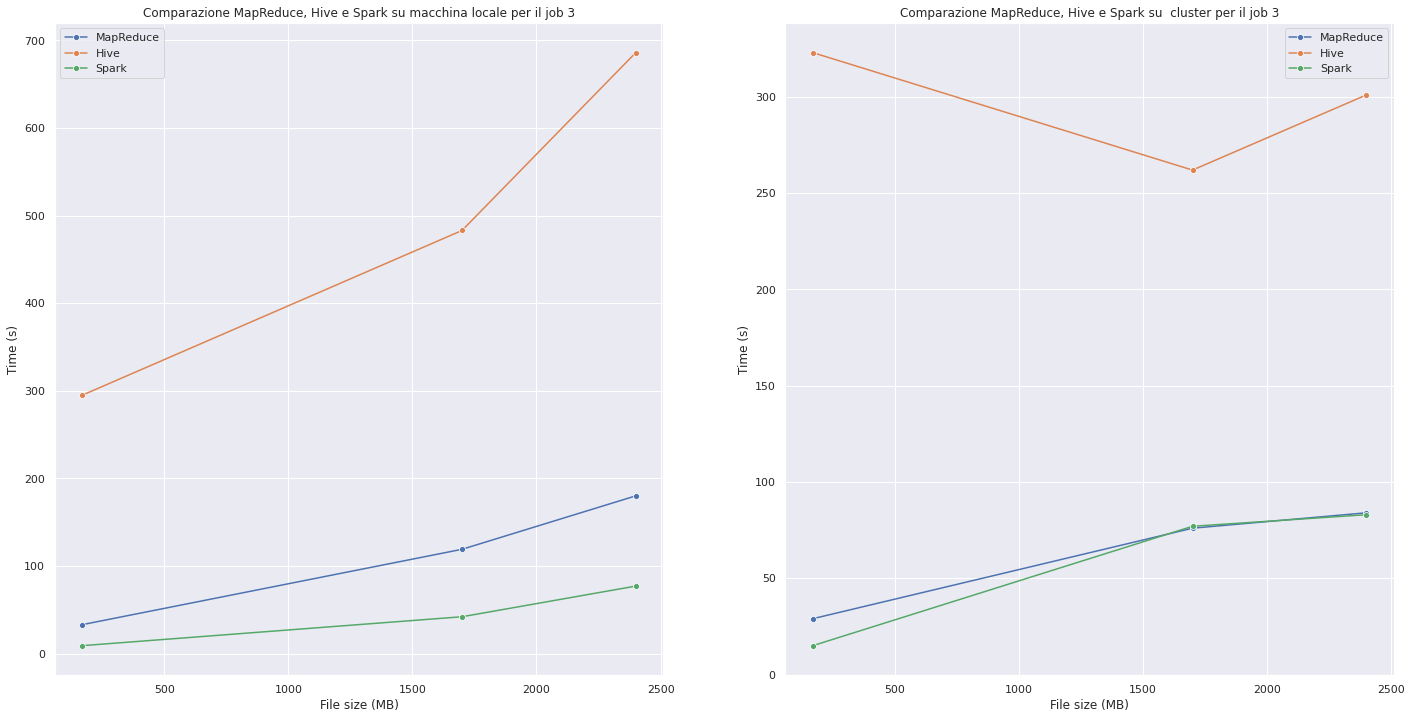

In [ ]:
compareOnLocalMachineAndCluster(3)